# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

<IPython.core.display.Javascript object>

## Loading Data

In [2]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

<IPython.core.display.Javascript object>

In [3]:
# Checking the number of rows and columns in the data
df_train.shape

(20000, 41)

<IPython.core.display.Javascript object>

In [4]:
# Checking the number of rows and columns in the data
df_test.shape

(5000, 41)

<IPython.core.display.Javascript object>

## Data Overview

In [5]:
data_train = df_train.copy()
data_test = df_test.copy()

<IPython.core.display.Javascript object>

In [6]:
# let's view the first 5 rows of the data
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


<IPython.core.display.Javascript object>

In [7]:
# let's view the last 5 rows of the data
data_train.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


<IPython.core.display.Javascript object>

In [8]:
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


<IPython.core.display.Javascript object>

In [9]:
data_test.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


<IPython.core.display.Javascript object>

In [10]:
# let's check the data types of the columns in the dataset
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

<IPython.core.display.Javascript object>

In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

<IPython.core.display.Javascript object>

- The training and test data both contain 41 columns including 40 variables and one target column.
- There are 20,000 observation in the training data while test data contain 5,000 observation. 
- We can see that 2 columns in training set have less than 20,000 non-null values i.e. columns have missing values.
- Also in test dataset the as same as trainig dataset, there are 2 columns which have less than 5,000 non-null values i.e. columns have missing values.

In [12]:
# let's check for duplicate values in the data
data_train.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [13]:
data_test.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [14]:
# let's check for missing values in the data
pd.DataFrame(round(data_train.isnull().sum() / data_train.isnull().count() * 100, 2)).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,0.090,0.090,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<IPython.core.display.Javascript object>

In [15]:
# let's check for missing values in the data
pd.DataFrame(round(data_test.isnull().sum() / data_test.isnull().count() * 100, 2)).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,0.100,0.120,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


<IPython.core.display.Javascript object>

- As it was mentioned above variable 1 and 2 (V1 and V2) have missing values in both dataset.
- Both V1 and V2 has less than 0.1% of missing values in training set and around 0.1% missing in test set.
- These data will be imputed later.

In [16]:
# Checking for the null value in the dataset
pd.DataFrame(data_train.isna().sum()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

* There are 18 null value in the V1 and V2 training dataset. 

In [17]:
# Checking for the null value in the dataset
pd.DataFrame(data_test.isna().sum()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

* There are 5 and 6 null value in the V1 and V2 test dataset respectively. 

**Let's check the number of unique values in each column**

In [18]:
pd.DataFrame(data_train.nunique()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,19982,19982,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,2


<IPython.core.display.Javascript object>

In [19]:
pd.DataFrame(data_test.nunique()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,4995,4994,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,2


<IPython.core.display.Javascript object>

In [20]:
data_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


<IPython.core.display.Javascript object>

In [21]:
data_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,4995.000,4994.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,-0.278,0.398,2.552,-0.049,-0.080,-1.042,-0.908,-0.575,0.030,0.019,-2.009,1.576,1.622,-0.921,-2.452,-3.019,-0.104,1.196,1.210,0.138,-3.664,0.962,-0.422,1.089,0.061,1.847,-0.552,-0.868,-1.096,-0.119,0.469,0.233,-0.080,-0.393,2.211,1.595,0.023,-0.406,0.939,-0.932,0.056
std,3.466,3.140,3.327,3.414,2.111,2.005,1.769,3.332,2.174,2.145,3.112,2.907,2.883,1.803,3.387,4.264,3.337,2.586,3.385,3.657,3.578,1.640,4.057,3.968,2.010,3.400,4.403,1.926,2.655,3.023,3.446,5.586,3.539,3.166,2.948,3.775,1.785,3.969,1.717,2.978,0.231
min,-12.382,-10.716,-9.238,-14.682,-7.712,-8.924,-8.124,-12.253,-6.785,-8.171,-13.152,-8.164,-11.548,-7.814,-15.286,-20.986,-13.418,-12.214,-14.170,-13.720,-16.341,-6.740,-14.422,-12.316,-6.770,-11.414,-13.177,-7.933,-9.988,-12.438,-11.263,-17.244,-14.904,-14.700,-12.261,-12.736,-5.079,-15.335,-5.451,-10.076,0.000
25%,-2.744,-1.649,0.315,-2.293,-1.615,-2.369,-2.054,-2.642,-1.456,-1.353,-4.050,-0.450,-0.126,-2.111,-4.479,-5.648,-2.228,-0.409,-1.026,-2.325,-5.944,-0.048,-3.163,-1.623,-1.298,-0.242,-3.663,-2.160,-2.861,-1.997,-1.822,-3.556,-2.348,-2.010,0.322,-0.866,-1.241,-2.984,-0.208,-2.987,0.000
50%,-0.765,0.427,2.260,-0.146,-0.132,-1.049,-0.940,-0.358,-0.080,0.166,-2.043,1.488,1.719,-0.896,-2.417,-2.774,0.047,0.881,1.296,0.193,-3.663,0.986,-0.279,0.913,0.077,1.917,-0.872,-0.931,-1.341,0.112,0.486,-0.077,-0.160,-0.172,2.112,1.703,-0.110,-0.381,0.959,-1.003,0.000
75%,1.831,2.444,4.587,2.166,1.341,0.308,0.212,1.713,1.450,1.511,0.044,3.563,3.465,0.272,-0.433,-0.178,2.112,2.604,3.526,2.540,-1.330,2.029,2.426,3.537,1.428,4.156,2.247,0.421,0.522,1.946,2.779,3.752,2.099,1.465,4.032,4.104,1.238,2.288,2.131,1.080,0.000
max,13.504,14.079,15.315,12.140,7.673,5.068,7.616,10.415,8.851,6.599,9.956,12.984,12.620,5.734,11.673,13.976,19.777,13.642,12.428,13.871,11.047,7.505,13.181,17.806,6.557,17.528,17.290,7.416,14.039,10.315,12.559,26.539,13.324,12.146,13.489,17.116,6.810,13.065,7.182,8.698,1.000


<IPython.core.display.Javascript object>

- As the data is the ciphered version, it is not possible to describe the data meaningfully.
- Most of the variable have mode near zero.
- In most of the variaables, the mode and the mean values are mostly near each other which shows that the distribution of the varibale are mostly normal.
- As the Target feature mean is near zero and the Target has two values, the data are mostly unbalanced to zero value.

In [22]:
data_train["Target"].value_counts()[0] / data_train["Target"].shape[0]

0.9445

<IPython.core.display.Javascript object>

In [23]:
data_train["Target"].value_counts()[1] / data_train["Target"].shape[0]

0.0555

<IPython.core.display.Javascript object>

In [24]:
data_test["Target"].value_counts()[0] / data_test["Target"].shape[0]

0.9436

<IPython.core.display.Javascript object>

In [25]:
data_test["Target"].value_counts()[1] / data_test["Target"].shape[0]

0.0564

<IPython.core.display.Javascript object>

- Near 95% of data in both dataset for Tagret column are zero
- The data are unbalanced.

## EDA

### Plotting histograms and boxplots for all the variables

In [26]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

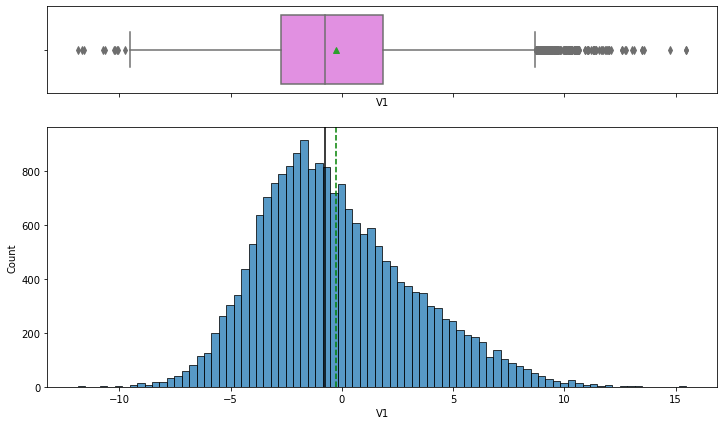

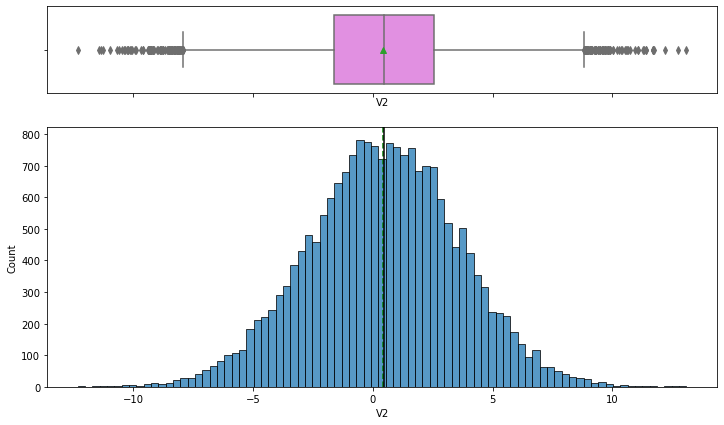

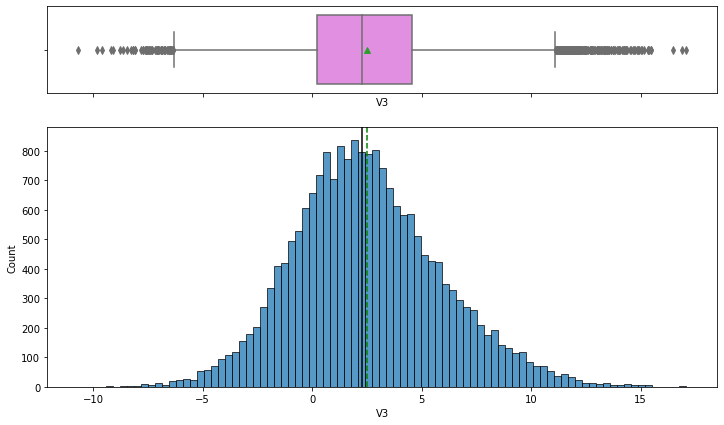

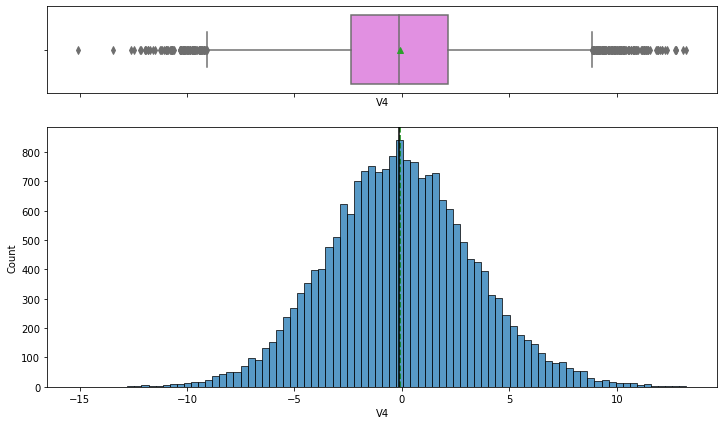

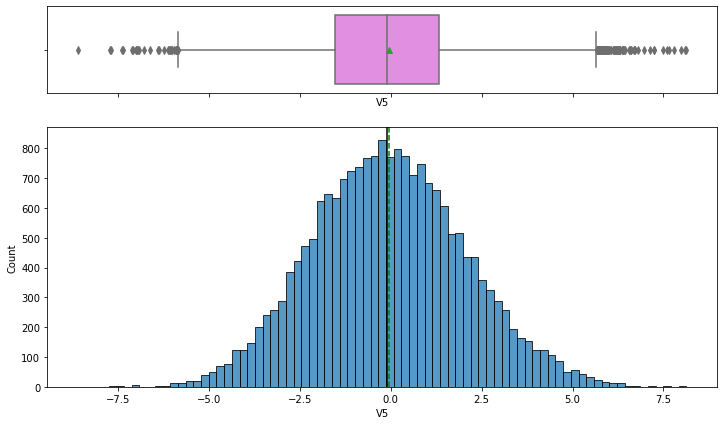

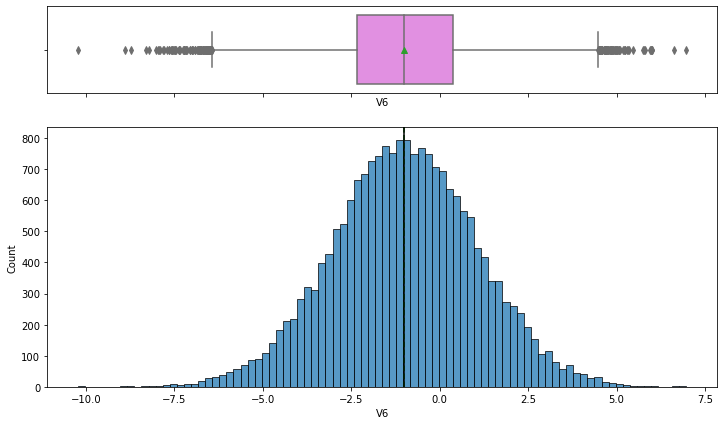

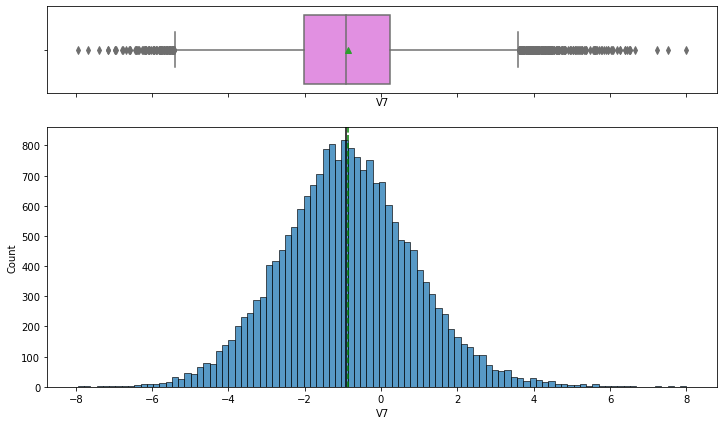

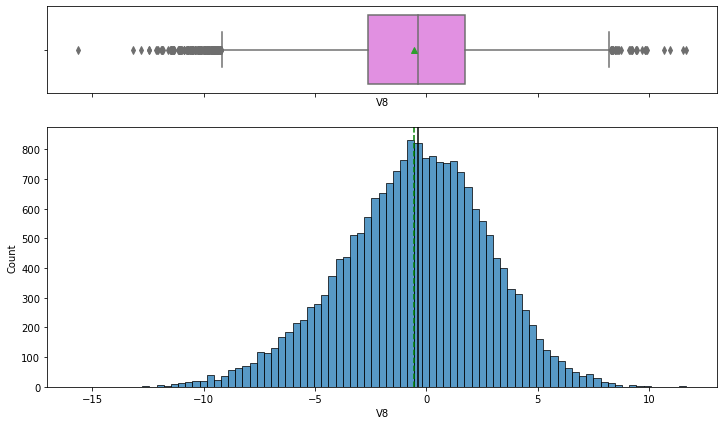

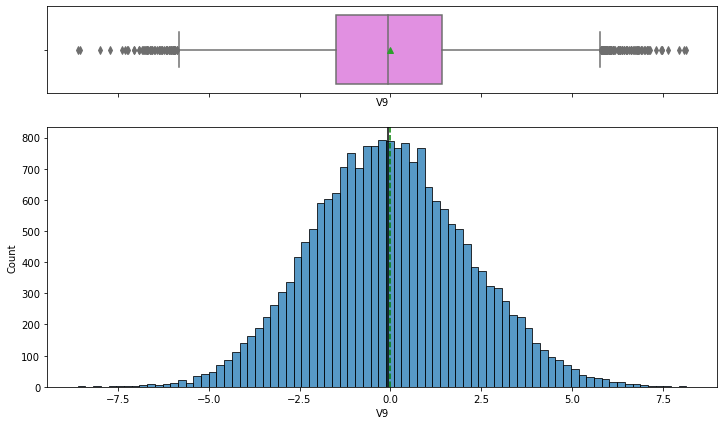

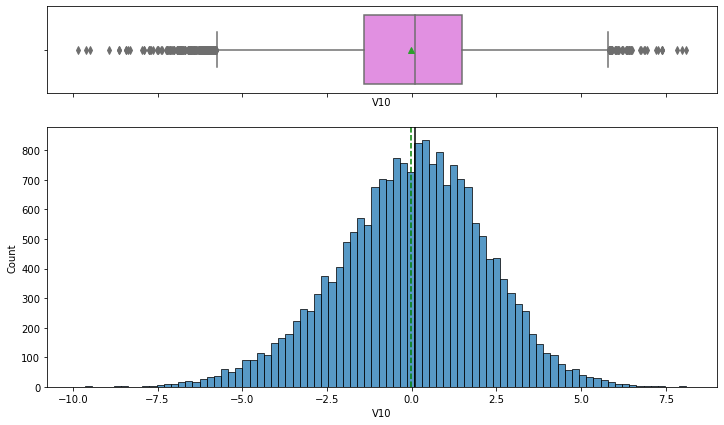

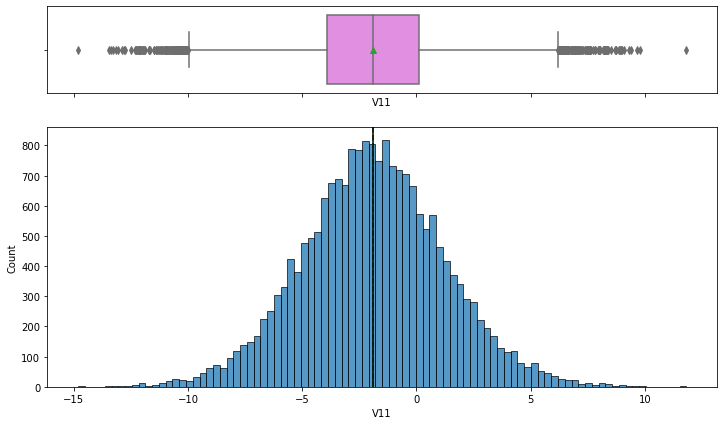

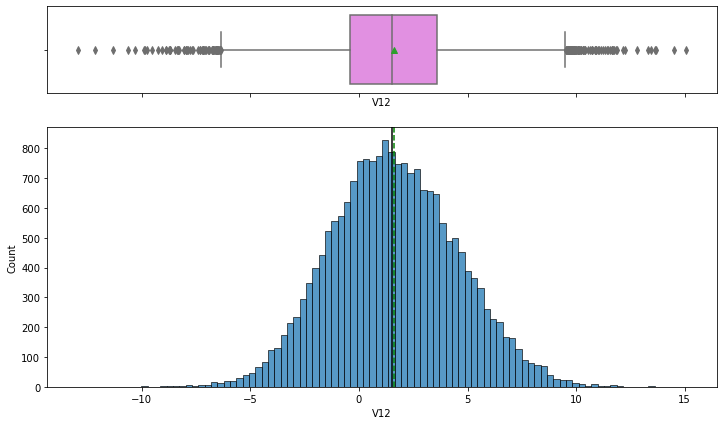

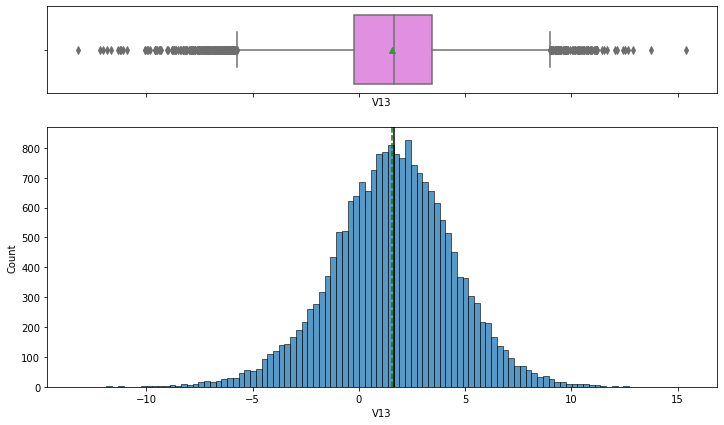

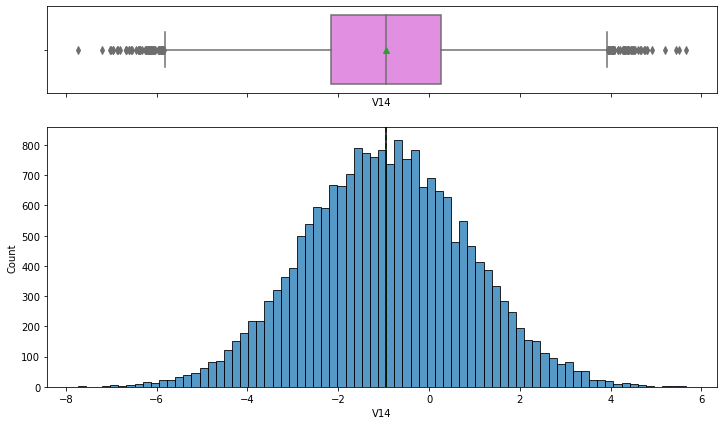

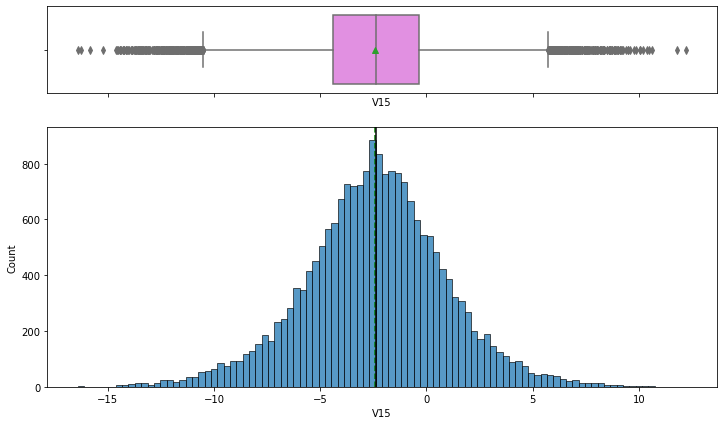

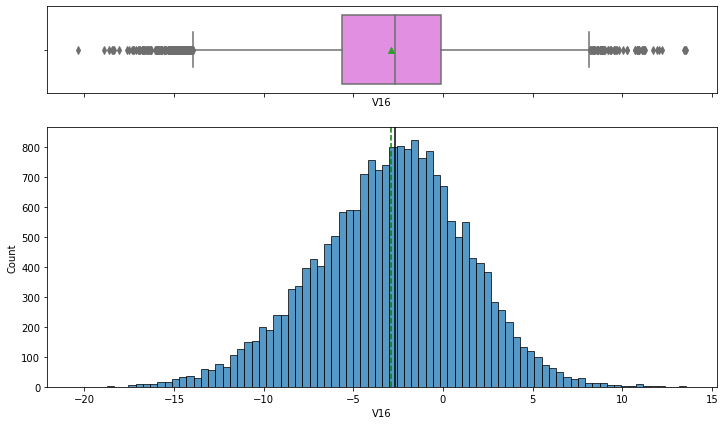

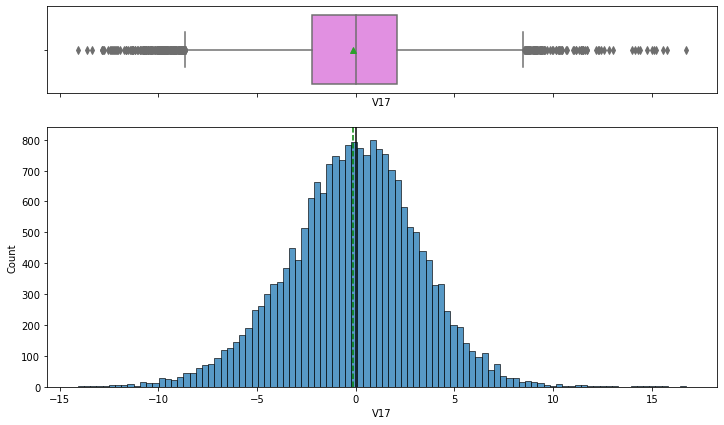

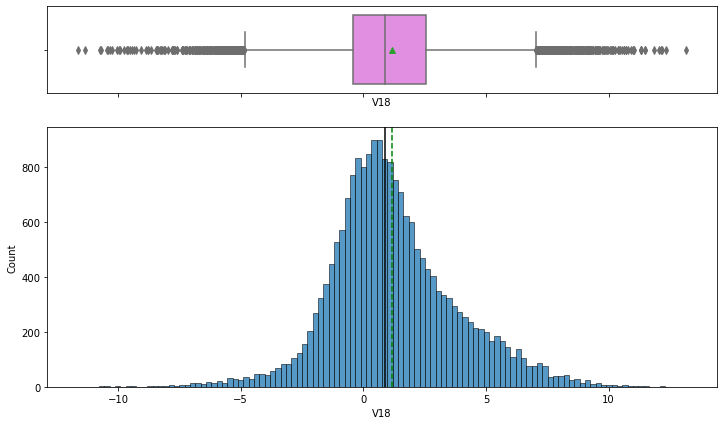

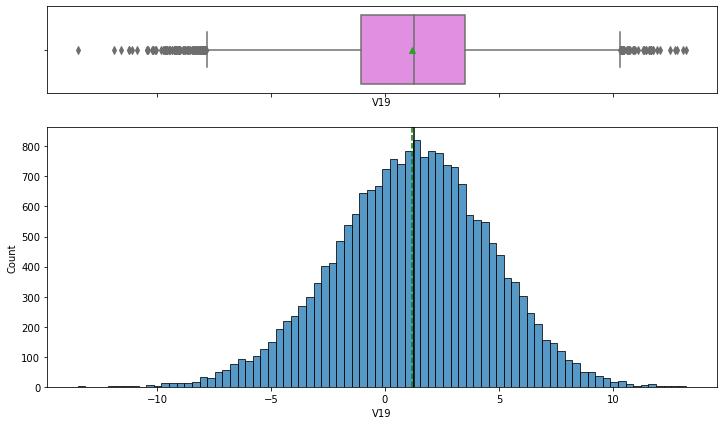

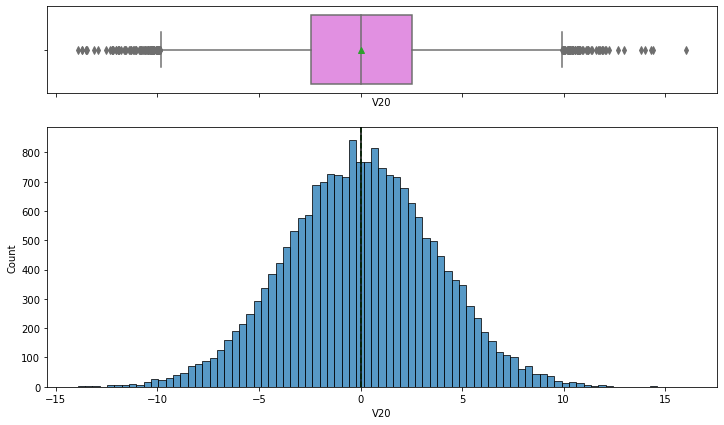

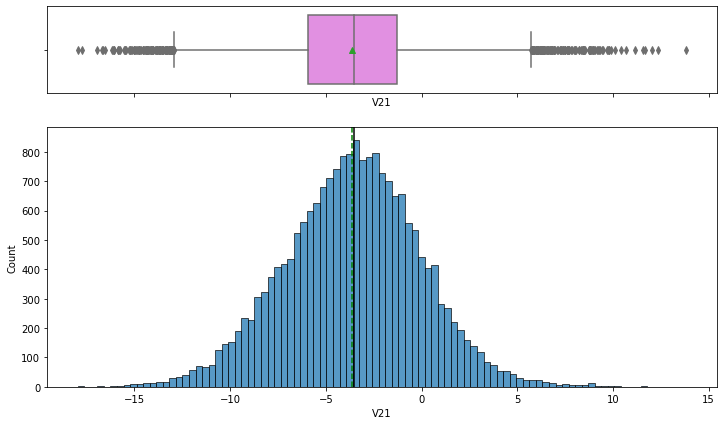

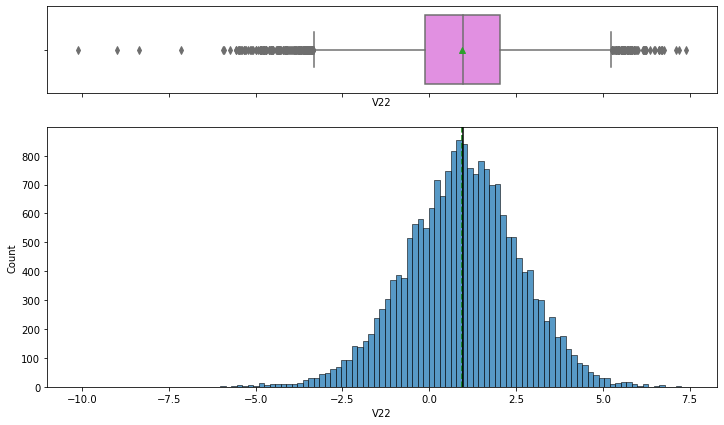

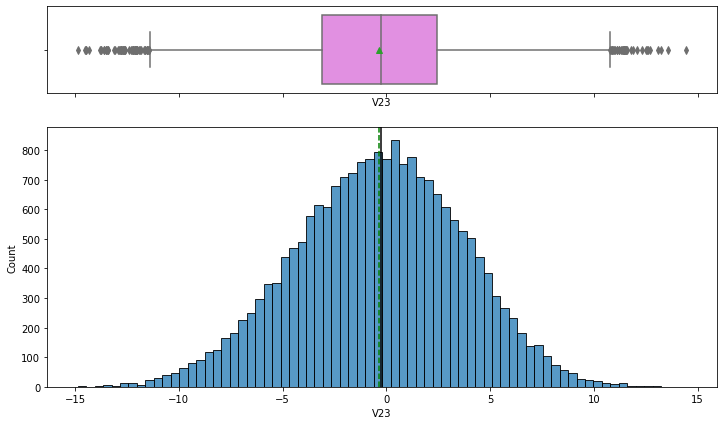

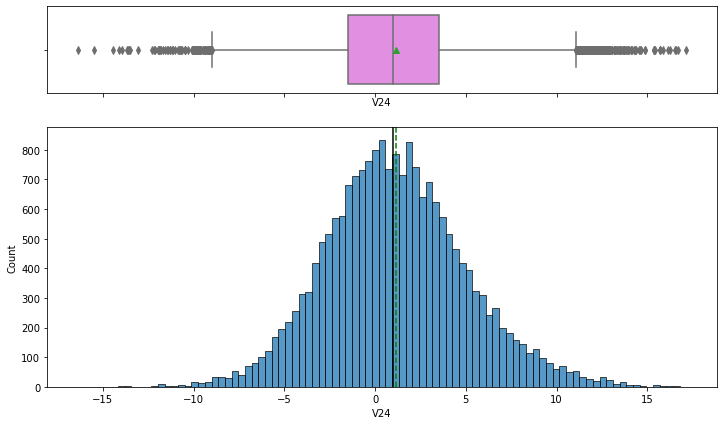

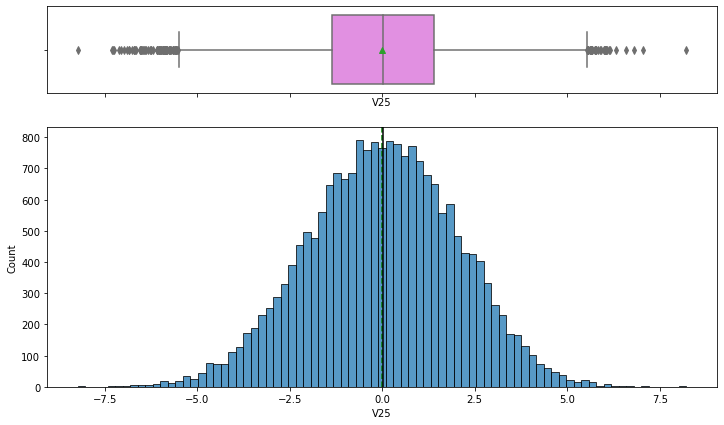

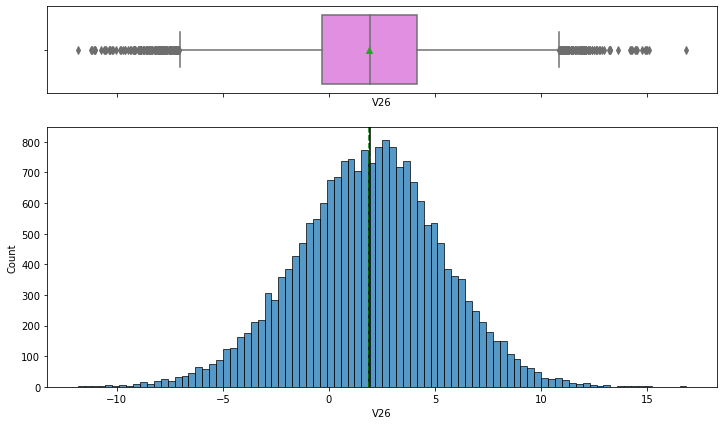

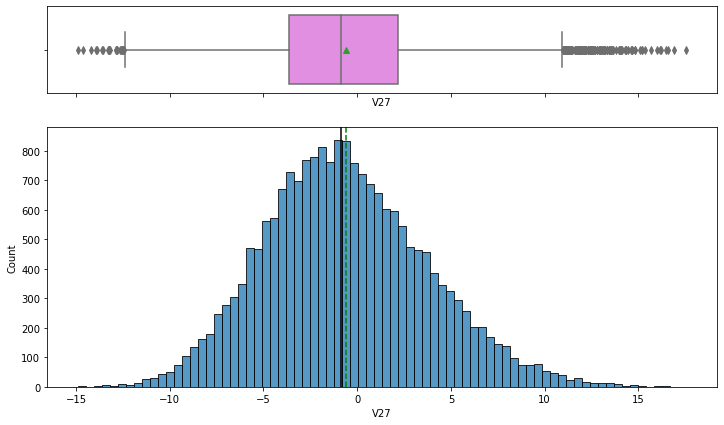

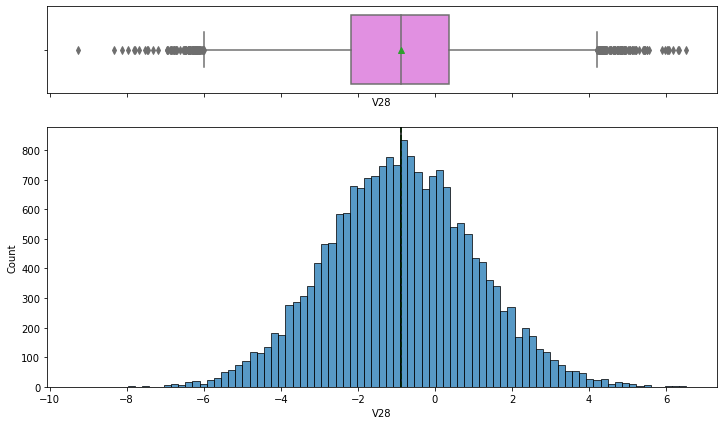

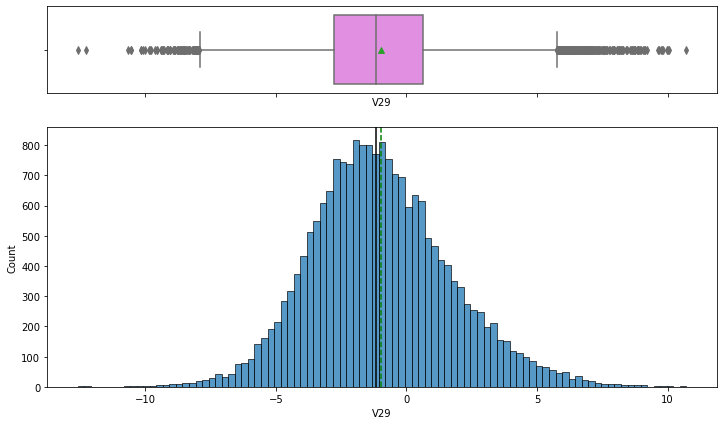

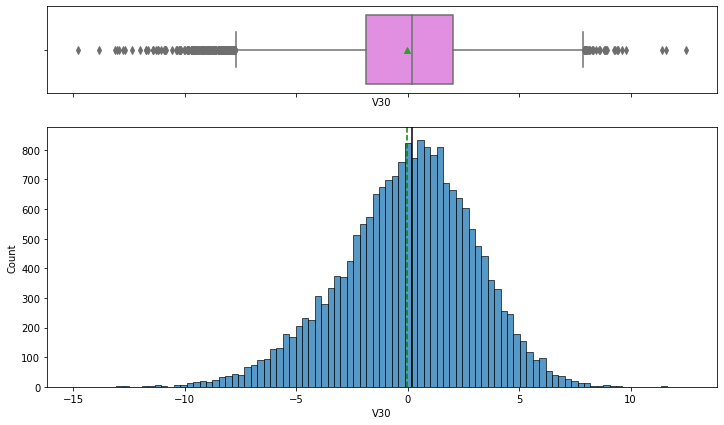

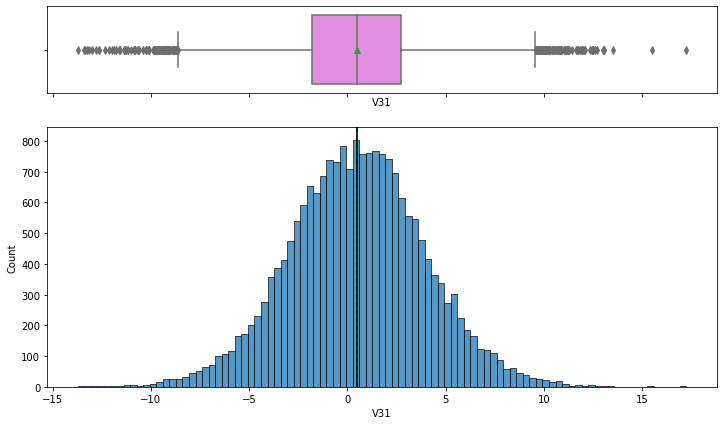

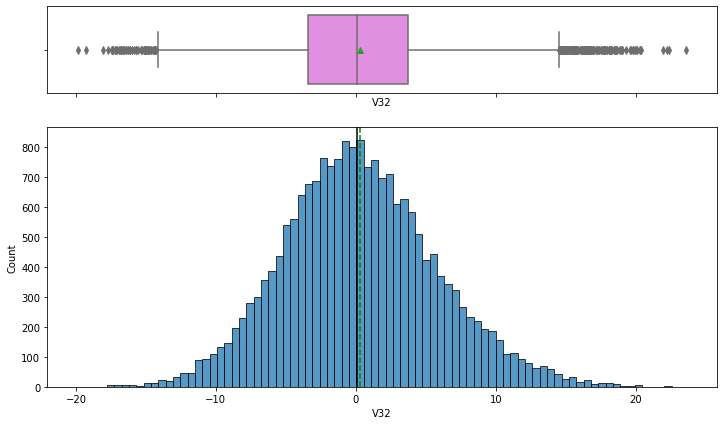

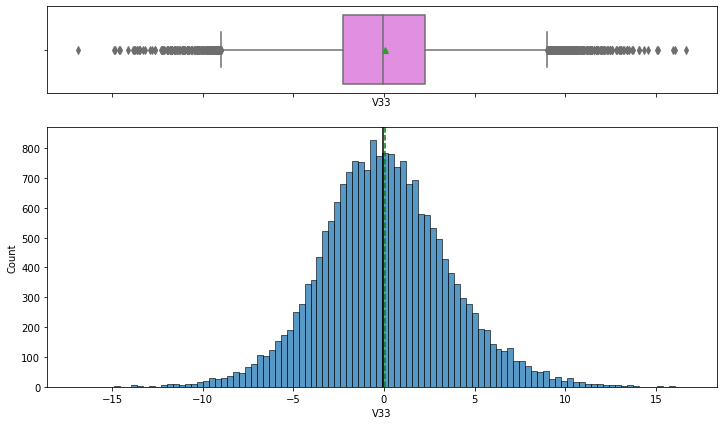

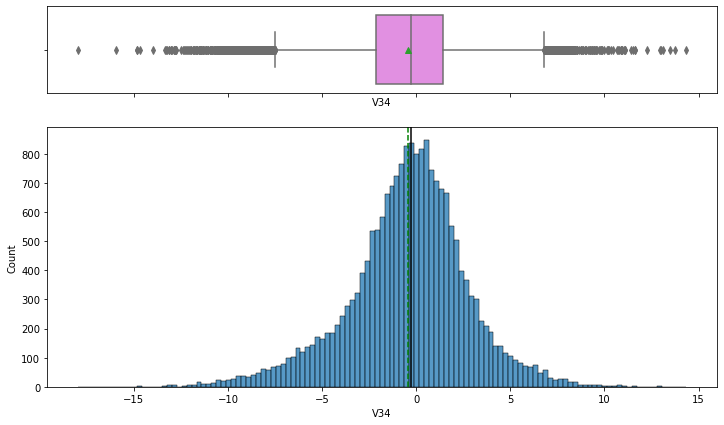

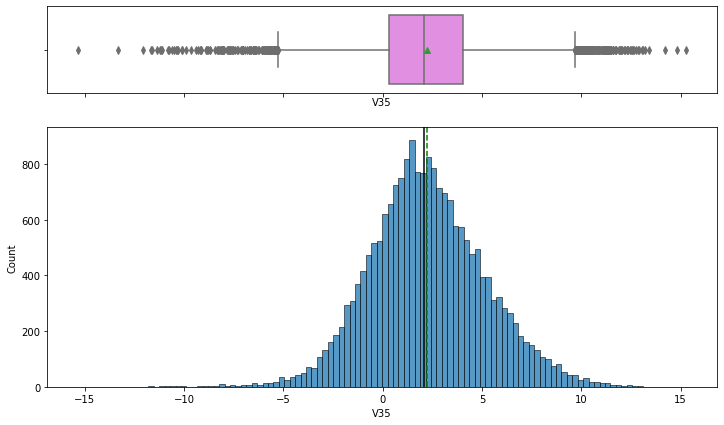

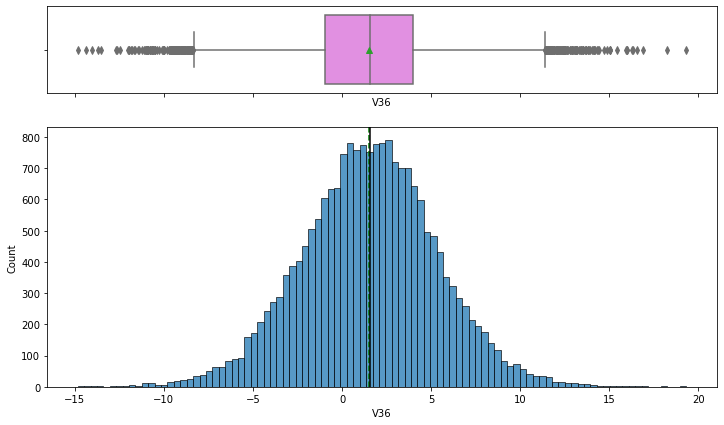

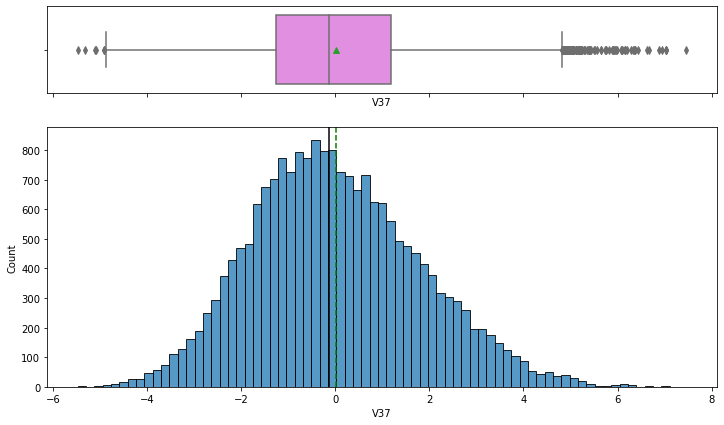

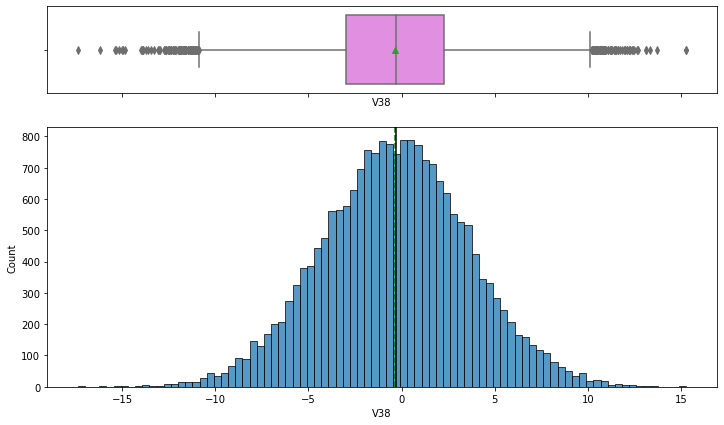

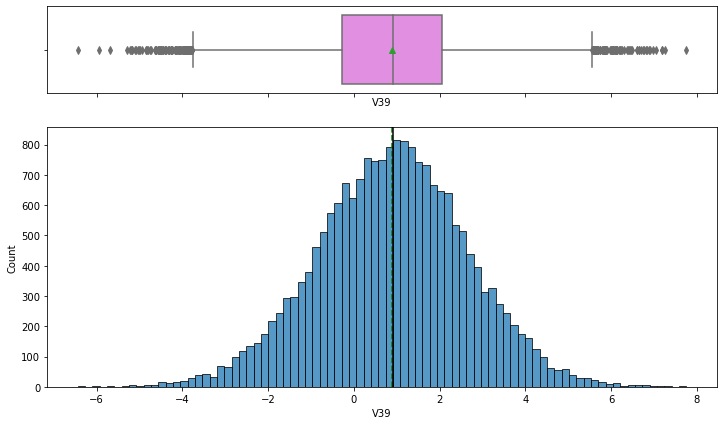

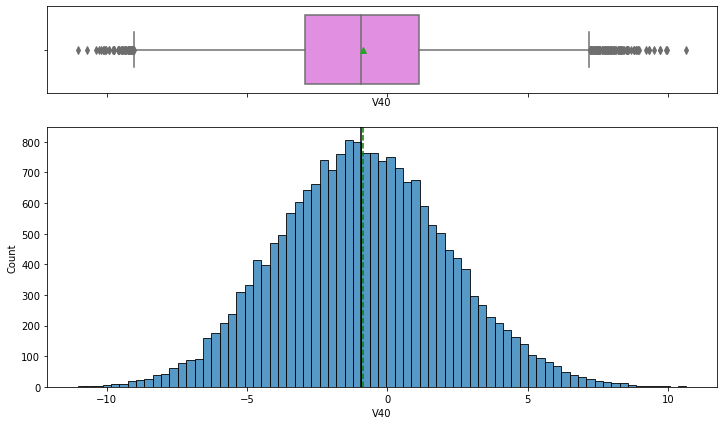

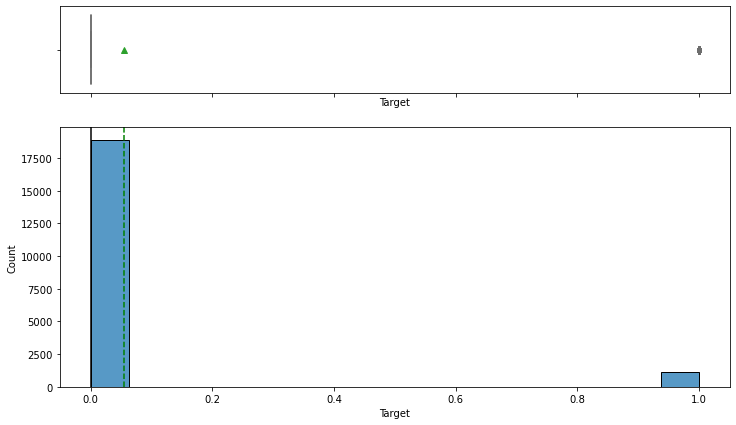

<IPython.core.display.Javascript object>

In [27]:
# Plotting all the features at one go
for feature in data_train.columns:
    histogram_boxplot(data_train, feature, figsize=(12, 7), kde=False, bins=None)

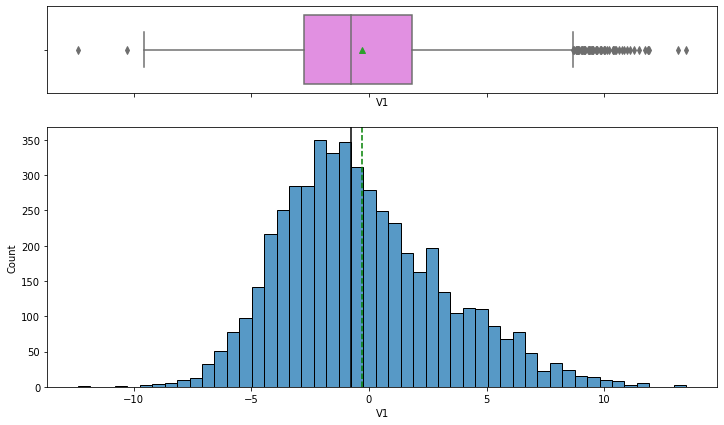

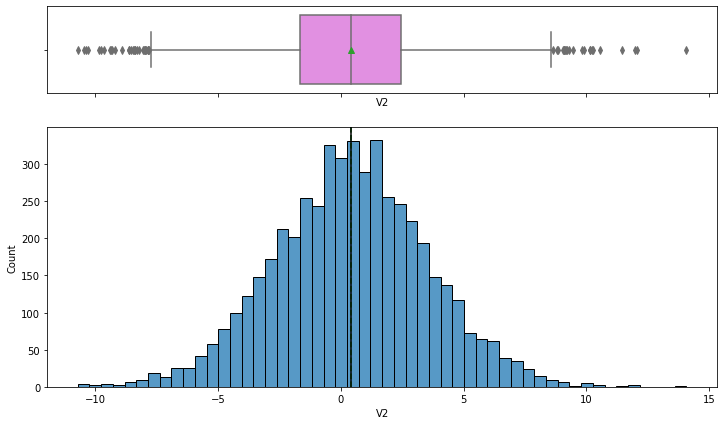

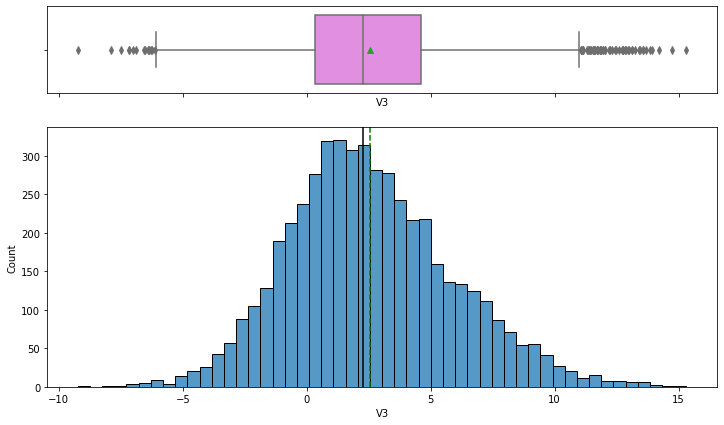

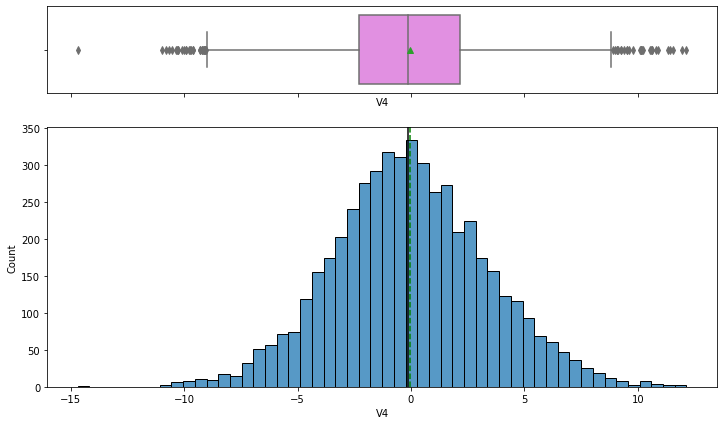

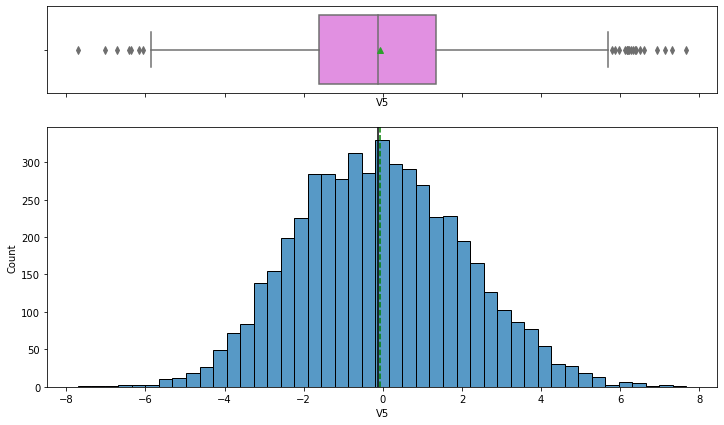

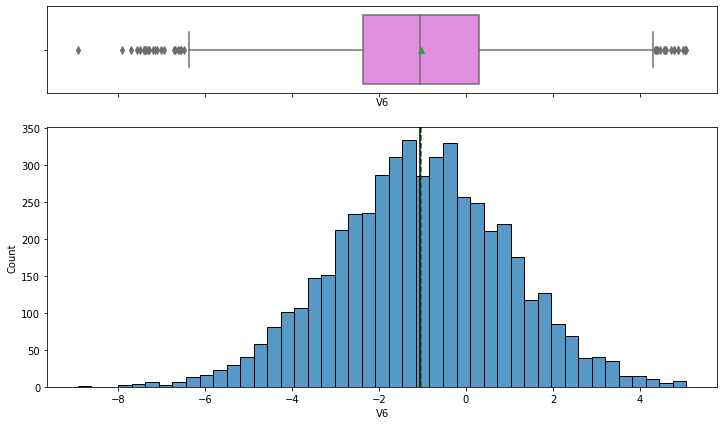

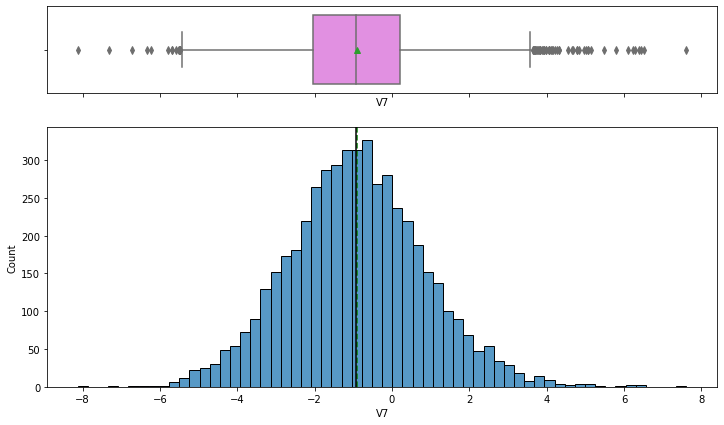

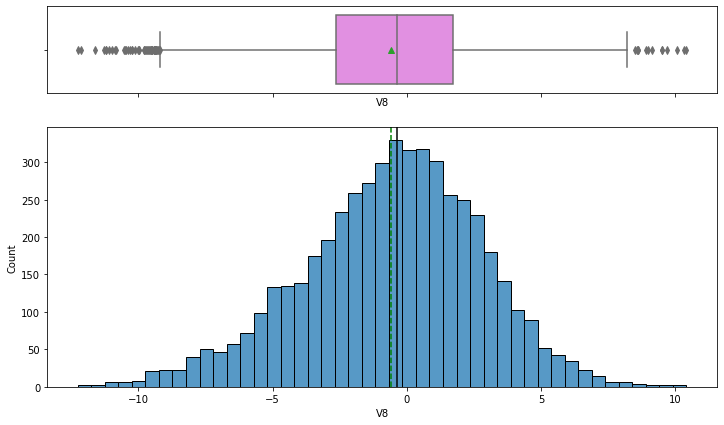

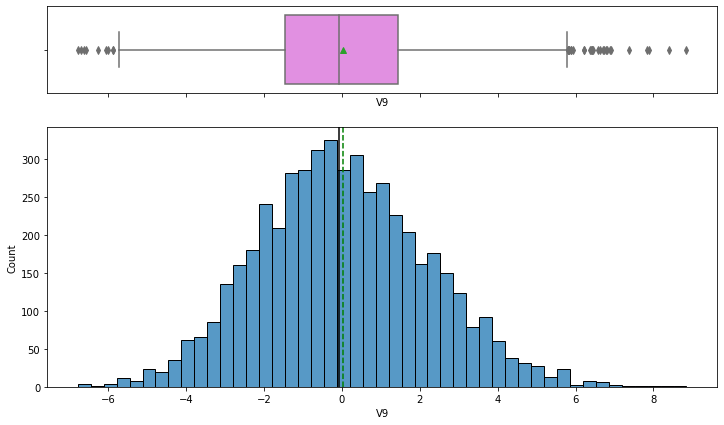

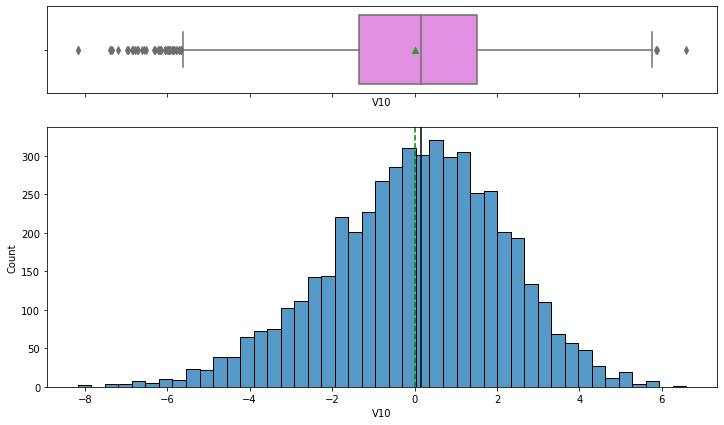

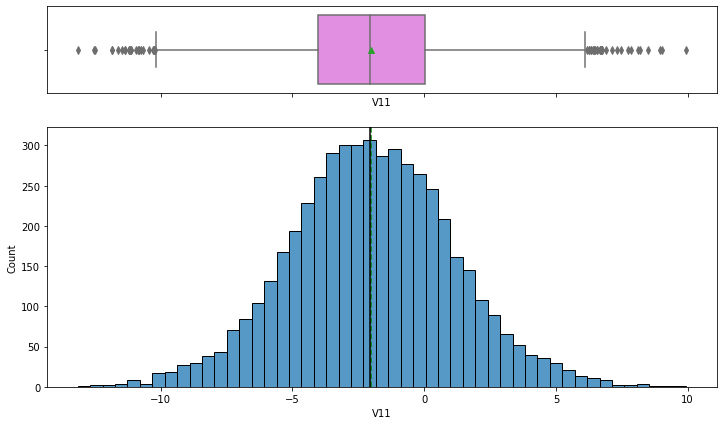

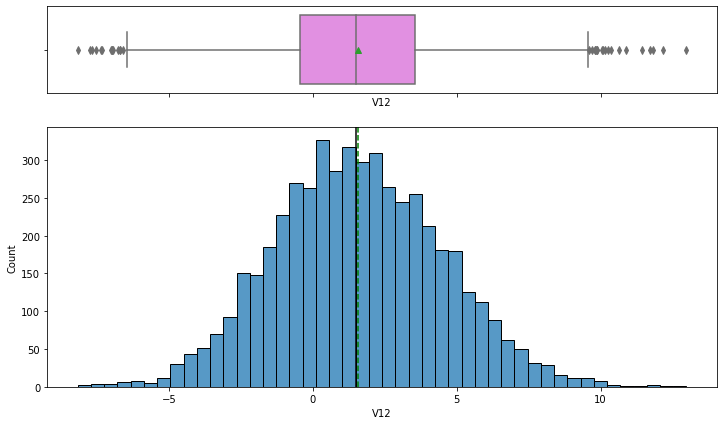

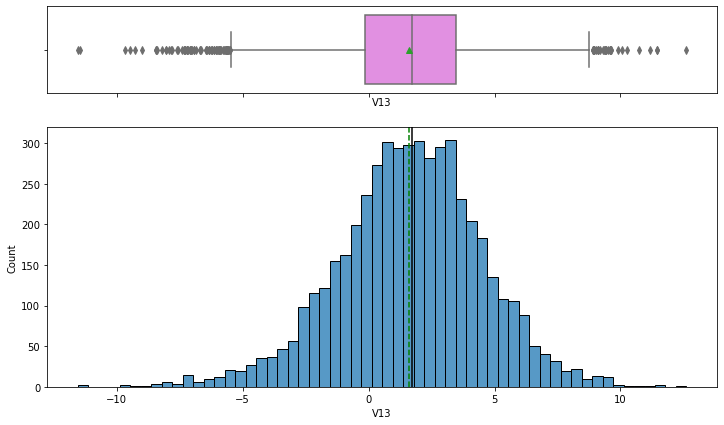

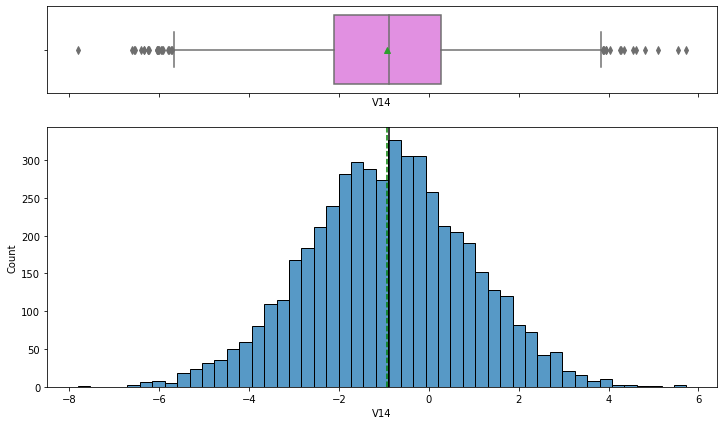

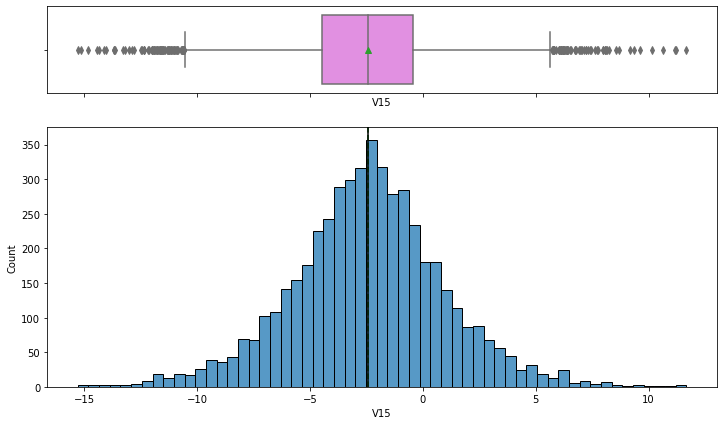

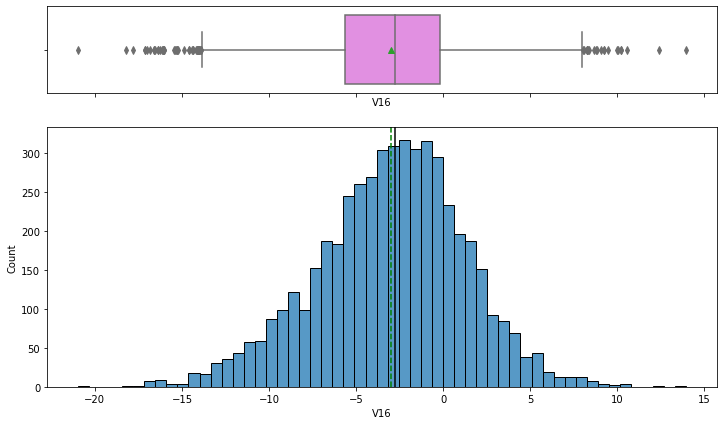

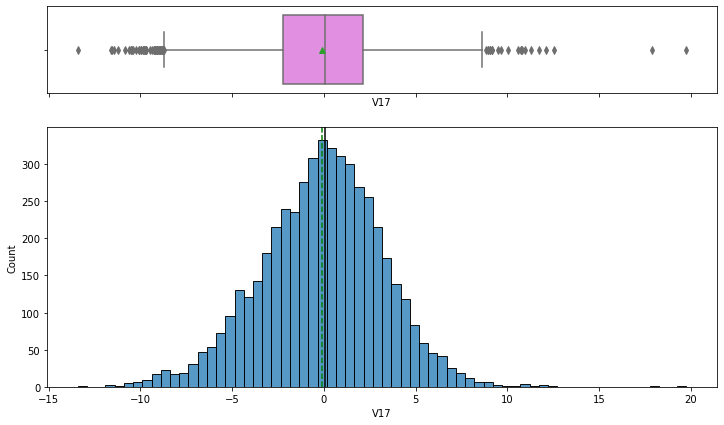

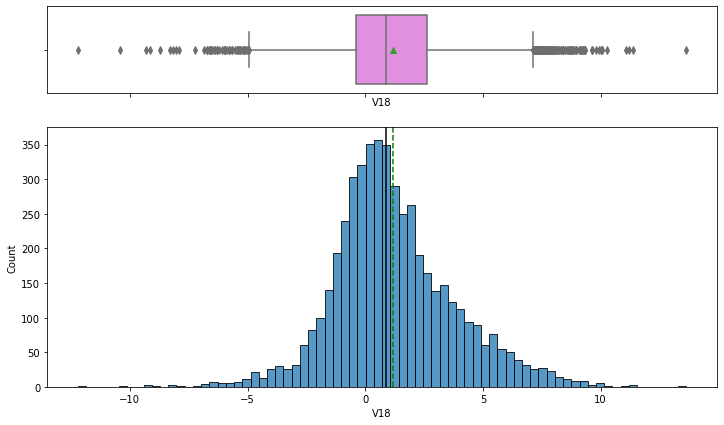

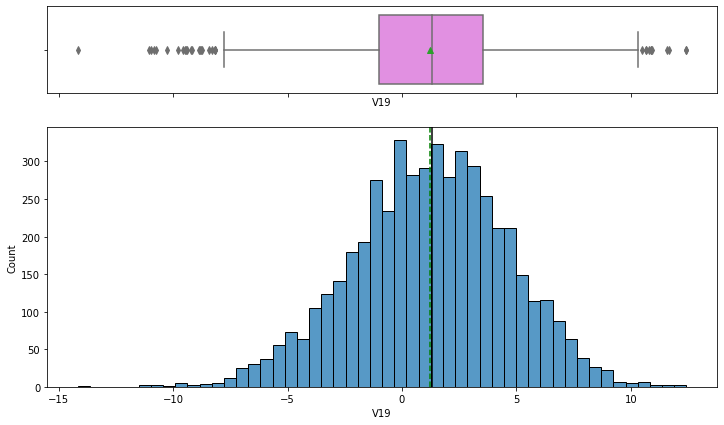

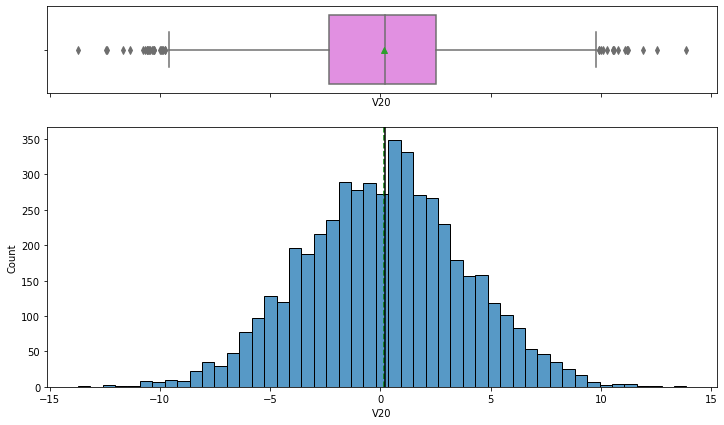

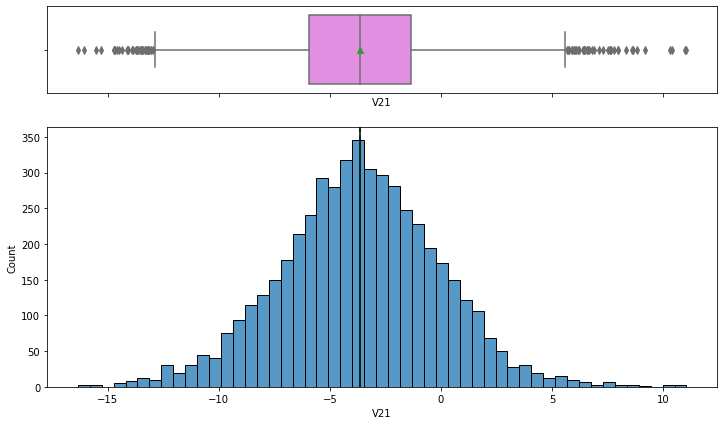

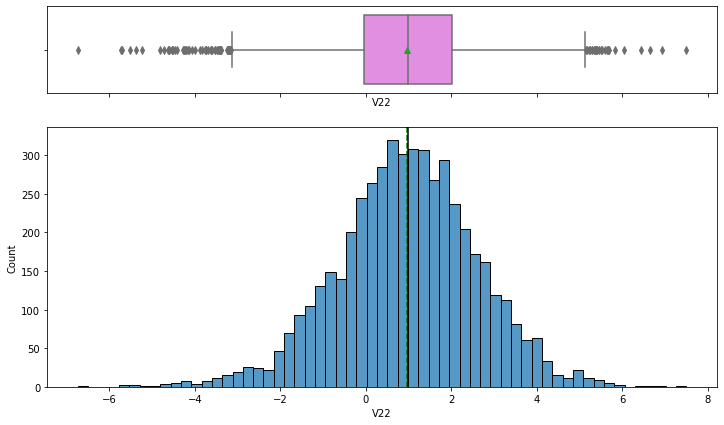

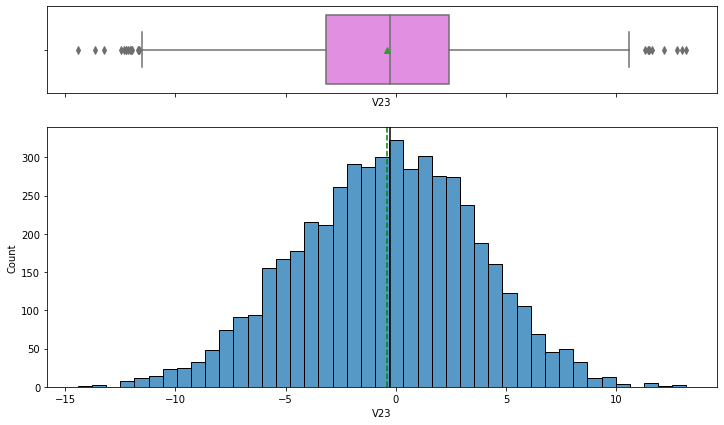

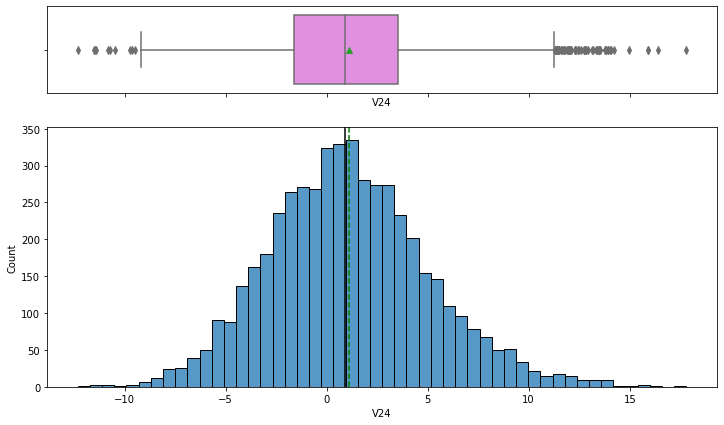

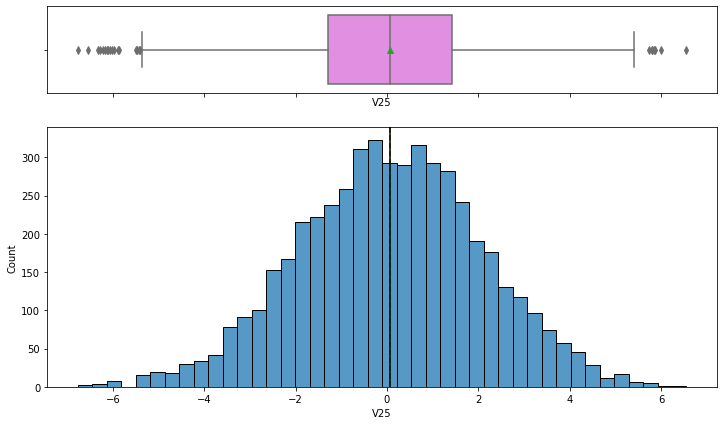

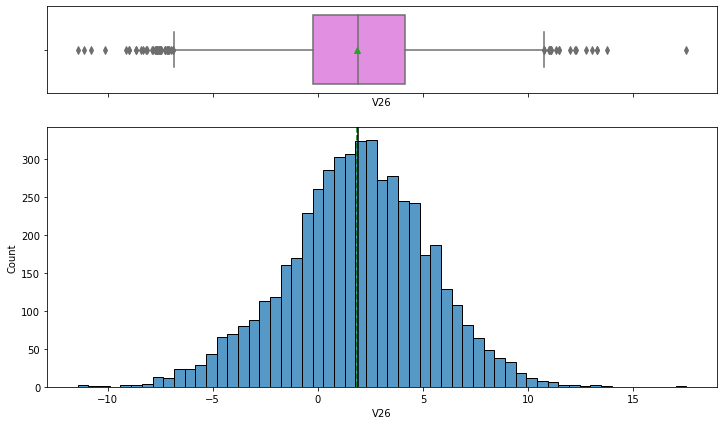

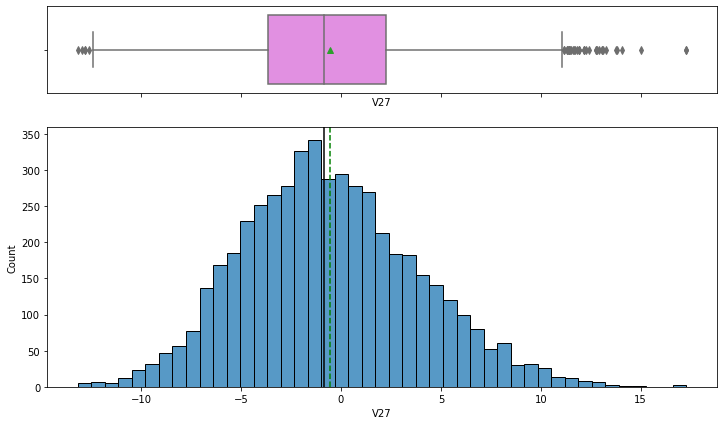

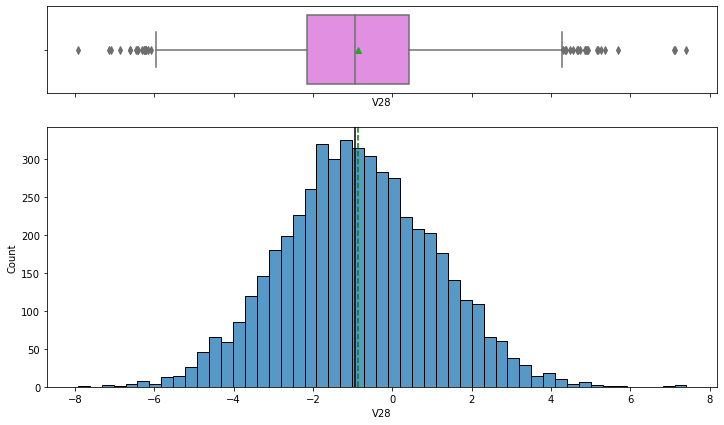

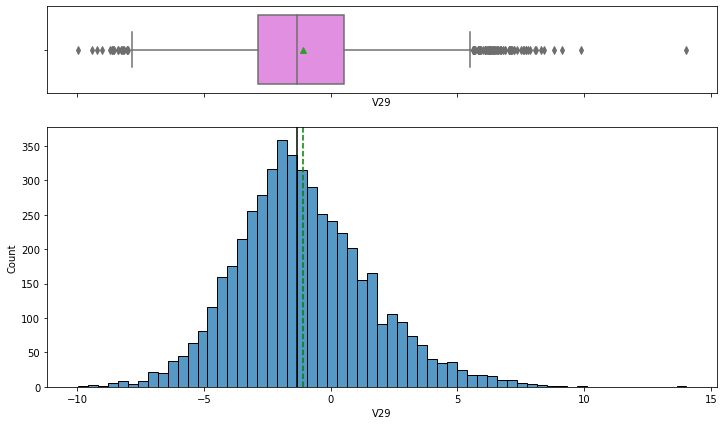

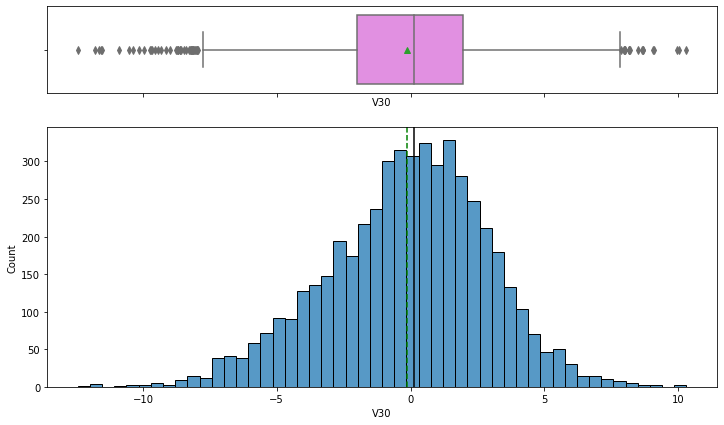

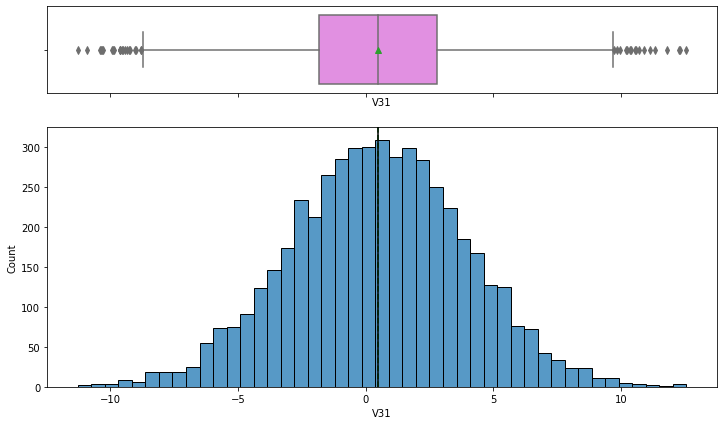

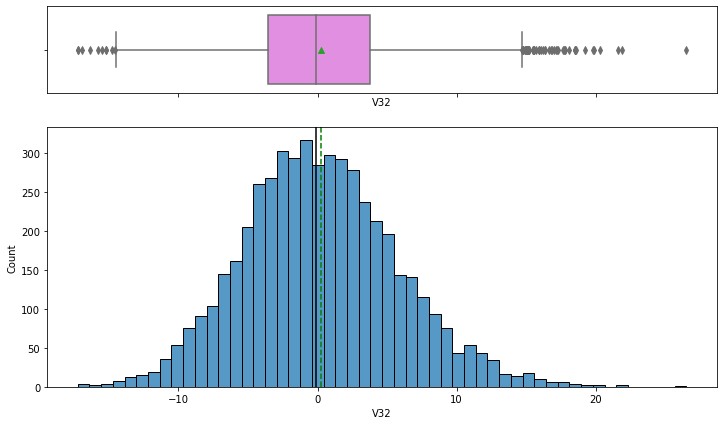

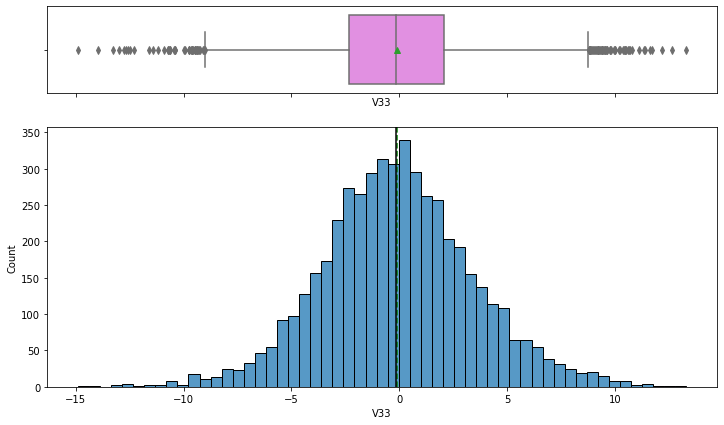

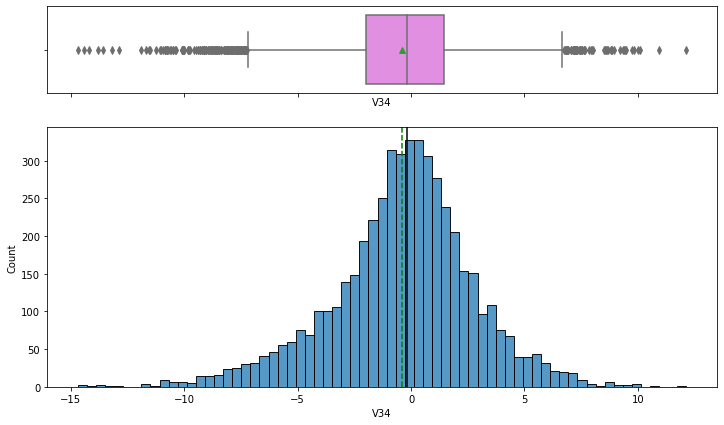

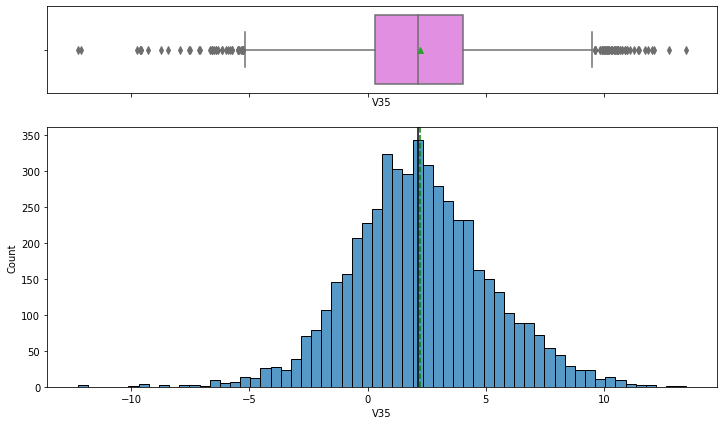

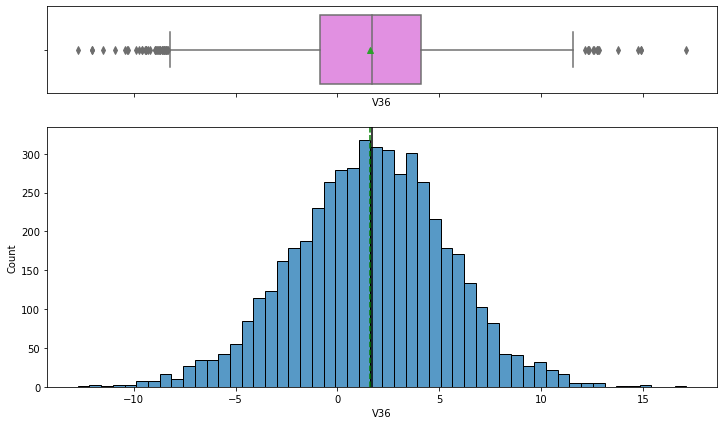

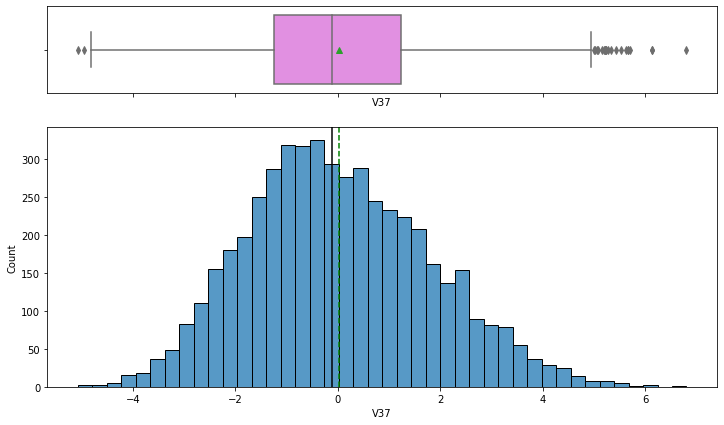

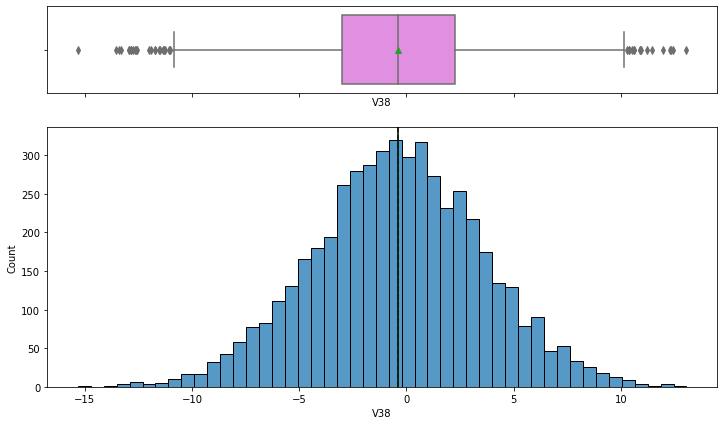

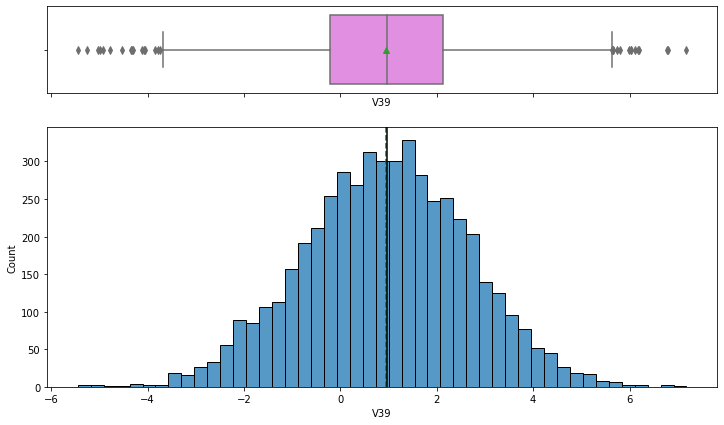

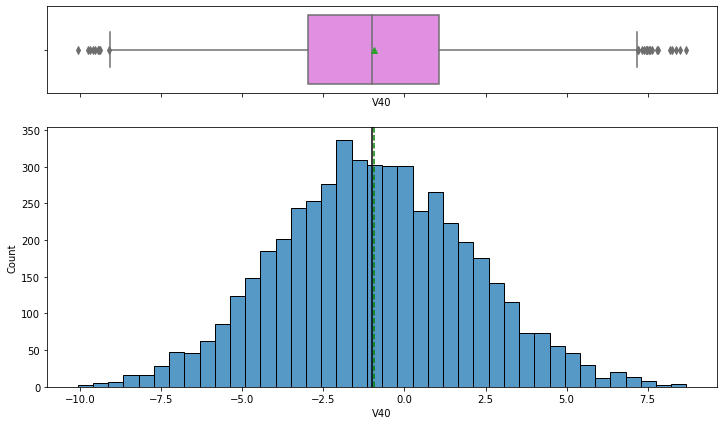

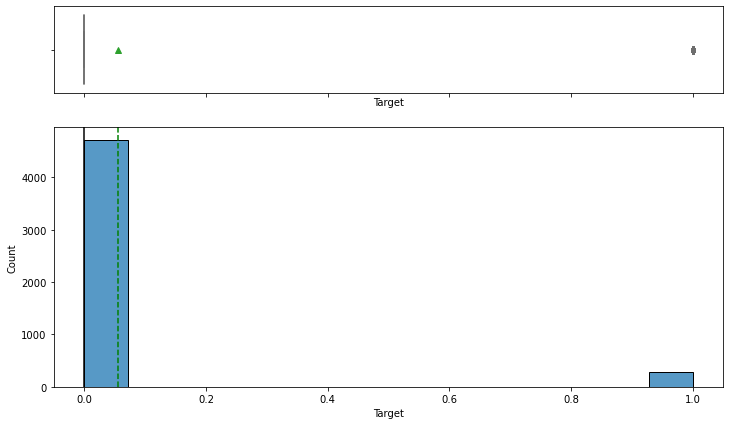

<IPython.core.display.Javascript object>

In [28]:
# Plotting all the features at one go
for feature in data_test.columns:
    histogram_boxplot(data_test, feature, figsize=(12, 7), kde=False, bins=None)

- As was mentioned above, the variables are mostly normally distributed in both training and test dataset.
- The mean and the mode of the most of variables are near zero. However some has more or less than zero.
- Some of the variables are slighltly skewed to the right or lest.
- The target is an unbalanced data with most frequency of zero in the data. (near 95% of zero, calculated in previous section) 

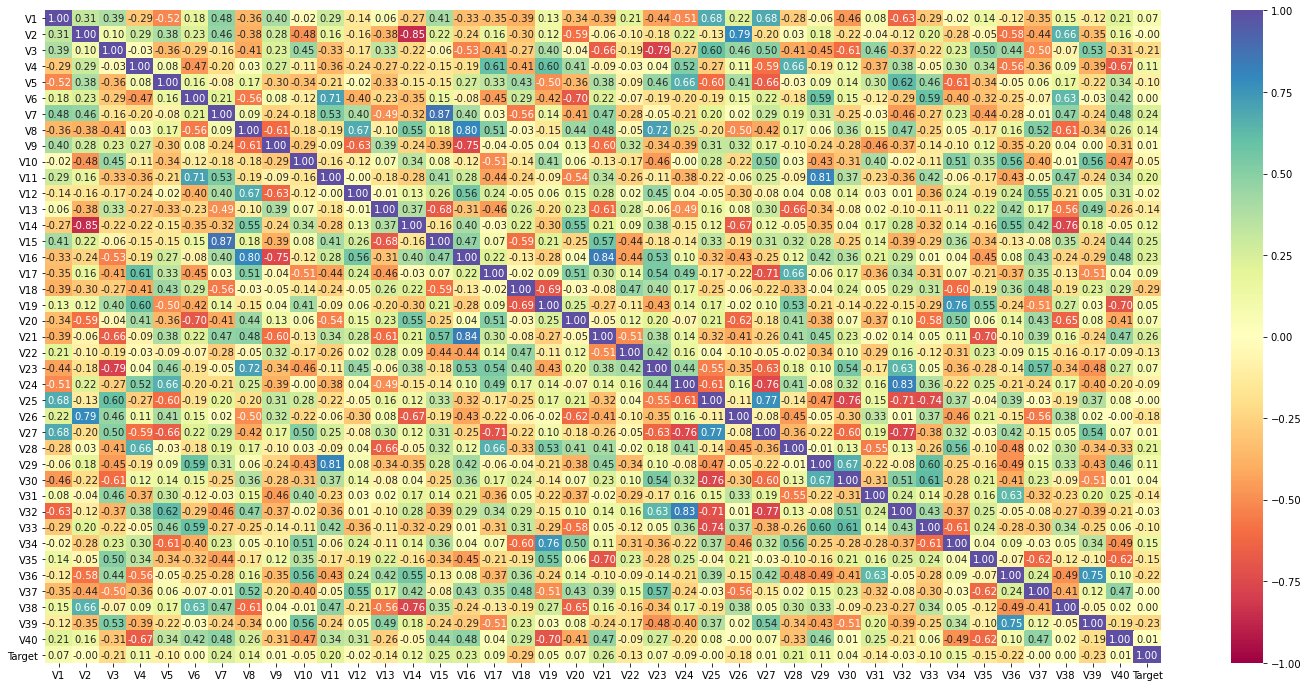

<IPython.core.display.Javascript object>

In [29]:
plt.figure(figsize=(25, 12))
sns.heatmap(data_train.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

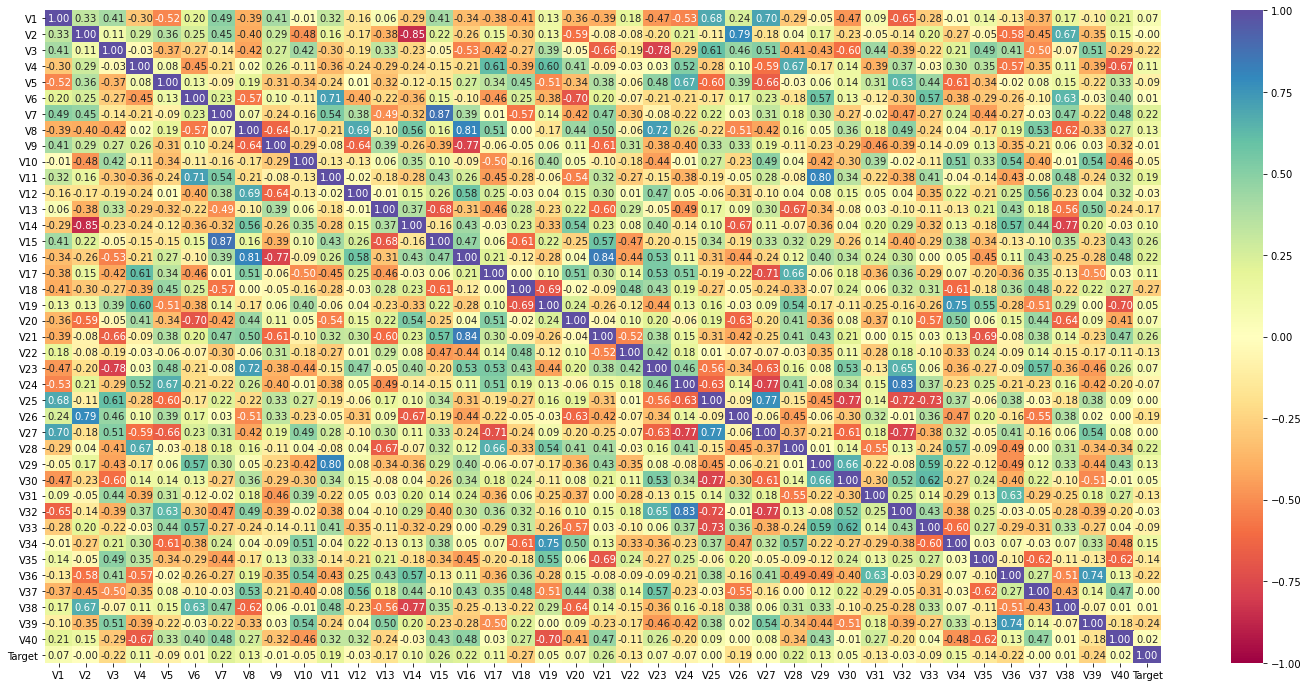

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=(25, 12))
sns.heatmap(data_test.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- Some variables have strong negative correlation to each other such as V2 and V14, or V3 and V23 in both dataset.
- Some variables have strong positive correaltion to each other such as V7 and V15, or V8 qnd V16 in both dataset.
- The correlation of the variables to the Targer variable are not too much.


<AxesSubplot:xlabel='V2', ylabel='V14'>

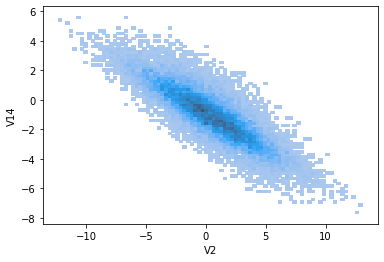

<IPython.core.display.Javascript object>

In [31]:
sns.histplot(data=data_train, x="V2", y="V14")

<AxesSubplot:xlabel='V7', ylabel='V15'>

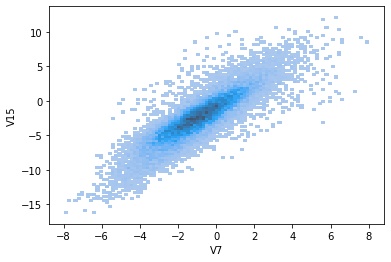

<IPython.core.display.Javascript object>

In [32]:
sns.histplot(data=data_train, x="V7", y="V15")

<AxesSubplot:xlabel='V2', ylabel='V14'>

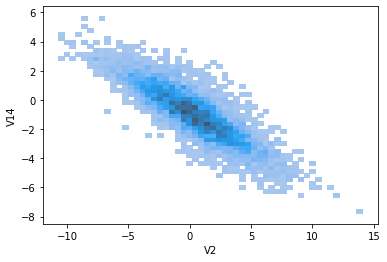

<IPython.core.display.Javascript object>

In [33]:
sns.histplot(data=data_test, x="V2", y="V14")

<AxesSubplot:xlabel='V7', ylabel='V15'>

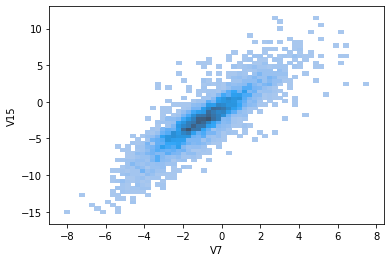

<IPython.core.display.Javascript object>

In [34]:
sns.histplot(data=data_test, x="V7", y="V15")

- Due to huge number of variables pairplot did not execute on the data. 
- In both dataset, strong negative and positive correlation between some pair variables are clear.

## Data Pre-processing

- In preprocessing I will try to treat the missing values on the data.

In [35]:
# Dividing training data into X and y
X = data_train.drop(["Target"], axis=1)
y = data_train["Target"]

X_test = data_test.drop(["Target"], axis=1)  # To drop target variable from test data
y_test = data_test["Target"]  # To store target variable in y_test

<IPython.core.display.Javascript object>

In [36]:
# Splitting data into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)  ## To split the data into train test in the ratio 80:20

print(X_train.shape, X_val.shape, X_test.shape)

(16000, 40) (4000, 40) (5000, 40)


<IPython.core.display.Javascript object>

* There are 16000 records for training, 4000 record for validation and 5000 record for test the model performance. 

### Missing-Value Treatment

* We will use mode to impute missing values in V1 and V2 columns

In [37]:
# Let's impute the missing values
imp_mode = SimpleImputer(missing_values=np.nan, strategy="mean")
cols_to_impute = ["V1", "V2"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

<IPython.core.display.Javascript object>

* Due to small number of null value in the dataset, it could be eliminated from the data. But here, with MEAN strategy, the null values are replaced.

In [38]:
# Checking for the null value in the dataset
pd.DataFrame(X_train.isna().sum()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [39]:
# Checking for the null value in the dataset
pd.DataFrame(X_val.isna().sum()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [40]:
# Checking for the null value in the dataset
pd.DataFrame(X_test.isna().sum()).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

- There is no more null value in all the datasets 

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

### Which metric to optimize?

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [41]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [42]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [43]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

<IPython.core.display.Javascript object>

### Model Building with original data

In [44]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.48988129245223133
dtree: 0.7196280073636767
Bagging: 0.7083222243382213
Random forest: 0.7195899193804354
Adaboost: 0.6215641465117756
GBM: 0.7173363803719928
Xgboost: 0.8096806957404941

Validation Performance:

Logistic regression: 0.49099099099099097
dtree: 0.7387387387387387
Bagging: 0.7207207207207207
Random forest: 0.7432432432432432
Adaboost: 0.6576576576576577
GBM: 0.7432432432432432
Xgboost: 0.7927927927927928


<IPython.core.display.Javascript object>

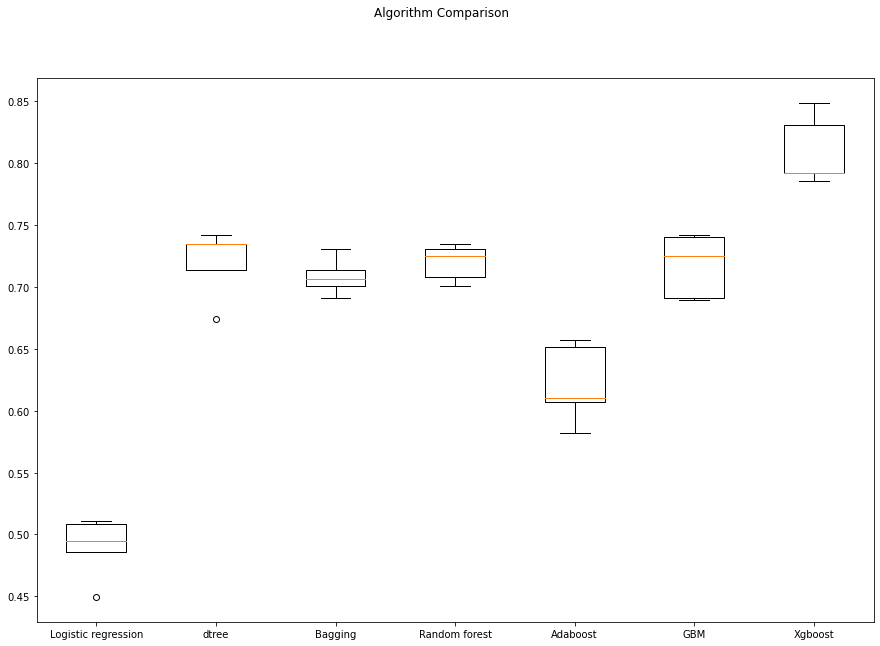

<IPython.core.display.Javascript object>

In [45]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 10))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

* We can see that the Xgboost is giving the highest cross-validated recall on original dataset.
* The boxplot shows that the performance of Xgboost is consistent and its performance on the validation set is also good on original dataset.
* As the data is unbalanced, therefore after applying oversampling and undersampling techniques then I will try to select the best models based on their performance to hypertune parameters and improve them to making the final model.  

### Model Building with Oversampled data


In [46]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [47]:
print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After UpSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After UpSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 888
Before UpSampling, counts of label 'No': 15112 

After UpSampling, counts of label 'Yes': 15112
After UpSampling, counts of label 'No': 15112 

After UpSampling, the shape of train_X: (30224, 40)
After UpSampling, the shape of train_y: (30224,) 



<IPython.core.display.Javascript object>

In [48]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.8812865538044636
dtree: 0.9730683335985987
Bagging: 0.9781630048735123
Random forest: 0.985375938672691
Adaboost: 0.8935280870047044
GBM: 0.9239674518302545
Xgboost: 0.9902064975930178

Validation Performance:

Logistic regression: 0.8513513513513513
dtree: 0.8198198198198198
Bagging: 0.8378378378378378
Random forest: 0.8558558558558559
Adaboost: 0.8558558558558559
GBM: 0.8828828828828829
Xgboost: 0.8693693693693694


<IPython.core.display.Javascript object>

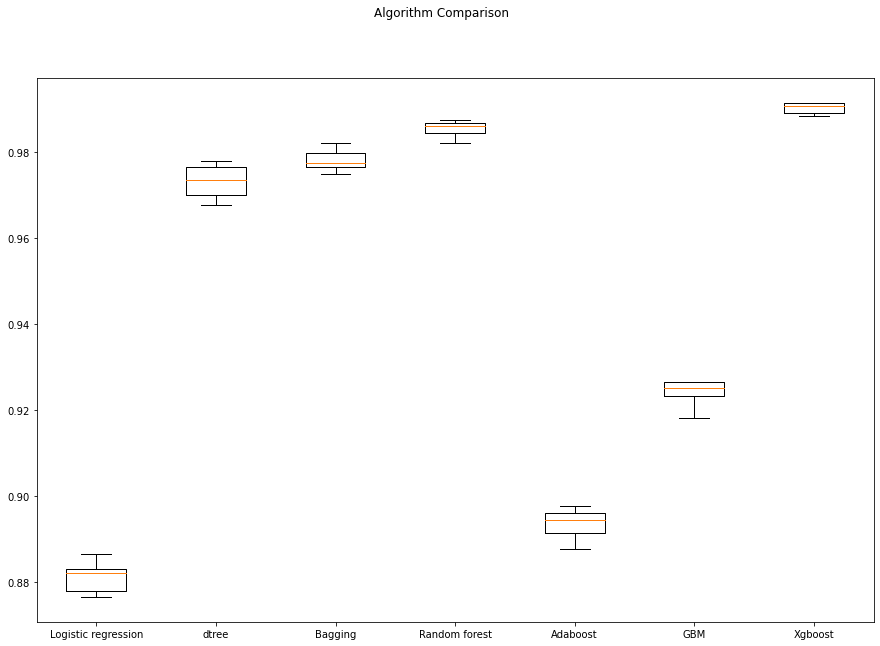

<IPython.core.display.Javascript object>

In [49]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 10))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names)

plt.show()

* We can see that the Xgboost is giving the highest cross-validated recall on oversampled dataset.
* After Xgboost technique, random forest, bagging and dtree are the best on cross-validated recall score. 
* But all the models are overfitted on the data, so the hyperparameters will be tuned on the next part to handle the overfitting problem. 
* After applying oversample technique and check the performance of cross validation result, I decided to continue to tune the hyperparameters of three models: 1- Xgboost 2- randon forest and 3- bagging

### Model Building with Undersampled data

In [50]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [51]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 888
Before Under Sampling, counts of label 'No': 15112 

After Under Sampling, counts of label 'Yes': 888
After Under Sampling, counts of label 'No': 888 

After Under Sampling, the shape of train_X: (1776, 40)
After Under Sampling, the shape of train_y: (1776,) 



<IPython.core.display.Javascript object>

In [52]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_un = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_un.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.8513235574176348
dtree: 0.8468355233923697
Bagging: 0.8704627689963816
Random forest: 0.8975052370976957
Adaboost: 0.8715927124992063
GBM: 0.8907446200723672
Xgboost: 0.8930108550752237

Validation Performance:

Logistic regression: 0.8648648648648649
dtree: 0.8468468468468469
Bagging: 0.8918918918918919
Random forest: 0.8783783783783784
Adaboost: 0.8558558558558559
GBM: 0.8873873873873874
Xgboost: 0.8918918918918919


<IPython.core.display.Javascript object>

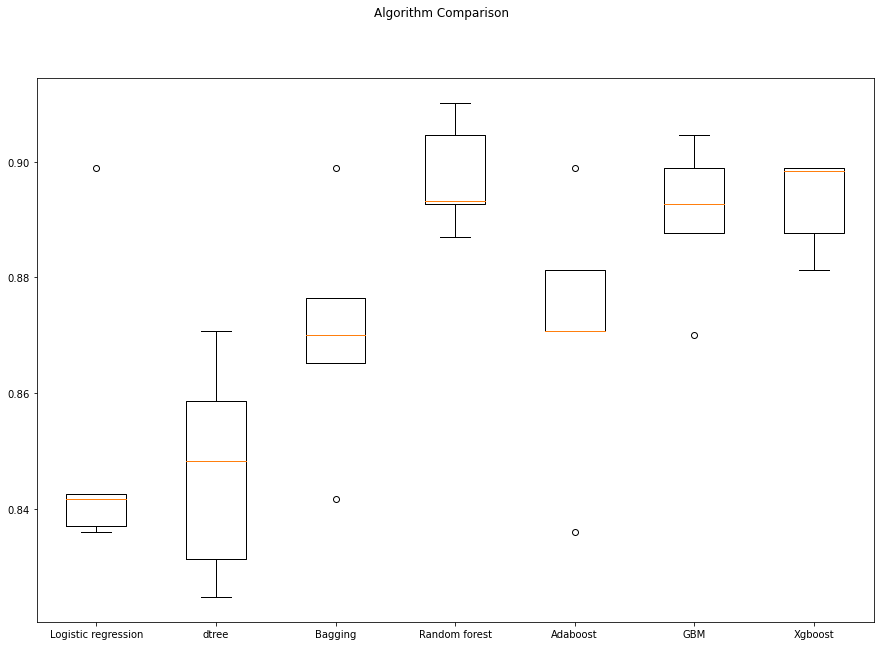

<IPython.core.display.Javascript object>

In [53]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 10))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_un)
ax.set_xticklabels(names)

plt.show()

* We can see that the Xgboost is giving the highest cross-validated recall on undersampled dataset.
* After Xgboost technique, random forest, gradient boosting are the best on cross-validated recall score. 
* In contrast to oversampled data, all the models are consistent and they are not overfitted. 
* After applying undersample technique and check the performance of cross validation result, I decided to continue to tune the hyperparameters of three models: 1- Xgboost 2- Gradient boosting 3- Random forest

## HyperparameterTuning 

## Tuning method for Bagging with oversampled data

In [54]:
%%time

# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "max_samples": [0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9],
    "n_estimators": [30, 50, 70],
}


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.9835892615034132:
Wall time: 17min 22s


<IPython.core.display.Javascript object>

In [55]:
# Creating new pipeline with best parameters
tuned_Bagging_over = BaggingClassifier(
    n_estimators=70, max_samples=0.9, max_features=0.9, random_state=1
)

# Fit the model on training data
tuned_Bagging_over.fit(X_train_over, y_train_over)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=70,
                  random_state=1)

<IPython.core.display.Javascript object>

In [56]:
# Calculating different metrics on training set
tuned_Bagging_over_train = model_performance_classification_sklearn(
    tuned_Bagging_over, X_train_over, y_train_over
)
print("Training performance:")
tuned_Bagging_over_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


<IPython.core.display.Javascript object>

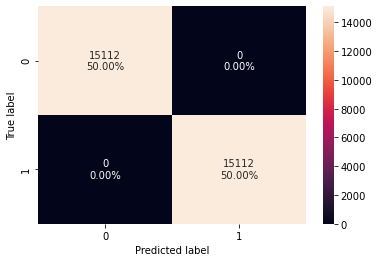

<IPython.core.display.Javascript object>

In [57]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_Bagging_over, X_train_over, y_train_over)

In [58]:
# Calculating different metrics on validation set
tuned_Bagging_over_val = model_performance_classification_sklearn(
    tuned_Bagging_over, X_val, y_val
)
print("Validation performance:")
tuned_Bagging_over_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.856,0.848,0.852


<IPython.core.display.Javascript object>

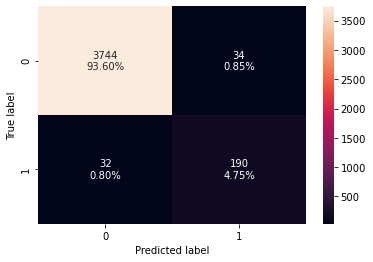

<IPython.core.display.Javascript object>

In [59]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_Bagging_over, X_val, y_val)

* The model is still suffering from overfitting problem.
* By the way the prediction power of the model is 85% on recall score which is good.
* The run time for tuning the model hyperparameters are around 18min (by available resource). 

## Tuning method for Random forest with oversampled data

In [60]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9808761331884627:
Wall time: 8min 13s


<IPython.core.display.Javascript object>

In [61]:
# Creating new pipeline with best parameters
tuned_rf_over = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=1,
    max_features="sqrt",
    max_samples=0.6,
    random_state=1,
)

# Fit the model on training data
tuned_rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                       random_state=1)

<IPython.core.display.Javascript object>

In [62]:
# Calculating different metrics on training set
tuned_rf_over_train = model_performance_classification_sklearn(
    tuned_rf_over, X_train_over, y_train_over
)
print("Training performance:")
tuned_rf_over_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,0.999,1.000,1.000


<IPython.core.display.Javascript object>

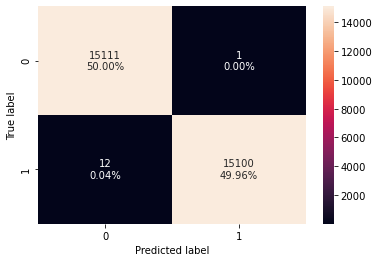

<IPython.core.display.Javascript object>

In [63]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_over, X_train_over, y_train_over)

In [64]:
# Calculating different metrics on validation set
tuned_rf_over_val = model_performance_classification_sklearn(
    tuned_rf_over, X_val, y_val
)
print("Validation performance:")
tuned_rf_over_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.988,0.860,0.918,0.888


<IPython.core.display.Javascript object>

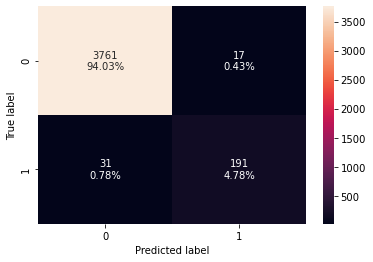

<IPython.core.display.Javascript object>

In [65]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_over, X_val, y_val)

* Although the model is still suffering from overfitting problem, but the prediction power of the model is 86% on recall score which is good.
* The run time for tuning the model hyperparameters are around 8min (by available resource).

## Tuning method for Xgboost with oversampled data

In [66]:
%%time

# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9959634200886083:
Wall time: 33min 55s
Compiler : 214 ms


<IPython.core.display.Javascript object>

In [67]:
# Creating new pipeline with best parameters
tuned_xgb_over = XGBClassifier(
    n_estimators=250,
    scale_pos_weight=10,
    learning_rate=0.1,
    gamma=5,
    subsample=0.9,
    eval_metric="logloss",
)

# Fit the model on training data
tuned_xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [68]:
# Calculating different metrics on training set
tuned_xgb_over_train = model_performance_classification_sklearn(
    tuned_xgb_over, X_train_over, y_train_over
)
print("Training performance:")
tuned_xgb_over_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.998,1.000,0.996,0.998


<IPython.core.display.Javascript object>

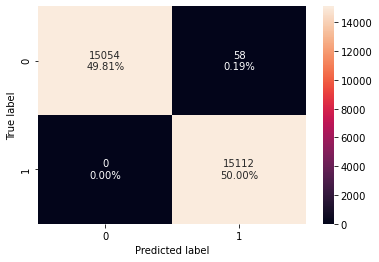

<IPython.core.display.Javascript object>

In [69]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_xgb_over, X_train_over, y_train_over)

In [70]:
# Calculating different metrics on validation set
tuned_xgb_over_val = model_performance_classification_sklearn(
    tuned_xgb_over, X_val, y_val
)
print("Validation performance:")
tuned_xgb_over_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.976,0.874,0.735,0.798


<IPython.core.display.Javascript object>

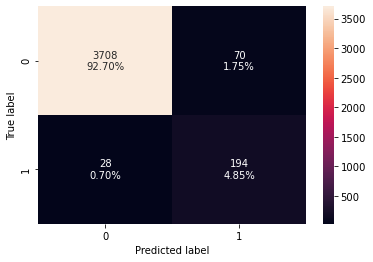

<IPython.core.display.Javascript object>

In [71]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_xgb_over, X_val, y_val)

* The model is still suffering from overfitting problem.
* By the way the prediction power of the model is 87% on recall score which is the best among all the models which are over samples and tuned.
* The run time for tuning the model hyperparameters are around 33min (by available resource).

## Tuning method for GBM with undersampled data

In [72]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.9020694470894431:
Wall time: 5min 25s
Parser   : 479 ms


<IPython.core.display.Javascript object>

In [73]:
# Creating new pipeline with best parameters
tuned_gb_under = GradientBoostingClassifier(
    n_estimators=125, max_features=0.5, learning_rate=0.2, subsample=0.7
)

# Fit the model on training data
tuned_gb_under.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

<IPython.core.display.Javascript object>

In [74]:
# Calculating different metrics on training set
tuned_gb_under_train = model_performance_classification_sklearn(
    tuned_gb_under, X_train_un, y_train_un
)
print("Validation performance:")
tuned_gb_under_train

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.993,0.988,0.999,0.993


<IPython.core.display.Javascript object>

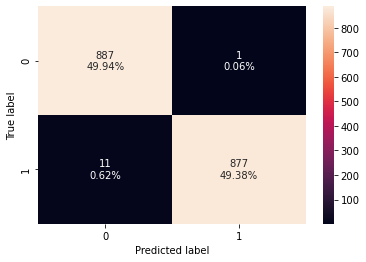

<IPython.core.display.Javascript object>

In [75]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_gb_under, X_train_un, y_train_un)

In [76]:
# Calculating different metrics on validation set
tuned_gb_under_val = model_performance_classification_sklearn(
    tuned_gb_under, X_val, y_val
)
print("Validation performance:")
tuned_gb_under_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.924,0.883,0.413,0.562


<IPython.core.display.Javascript object>

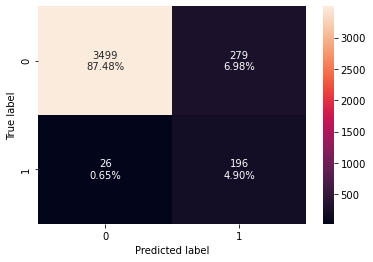

<IPython.core.display.Javascript object>

In [77]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_gb_under, X_val, y_val)

* The same as the oversampled data the model is suffering from overfitting problem but lower than the oversampling data.
* By the way the prediction power of the model is 88% on recall score which is better than all the over sampled data.
* The run time for tuning the model hyperparameters are around 6min (by available resource).

## Tuning method for Random forest with undersampled data

In [78]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }


# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8941979305529106:
Wall time: 38.8 s


<IPython.core.display.Javascript object>

In [79]:
# Creating new pipeline with best parameters
tuned_rf_under = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf=2,
    max_features="sqrt",
    max_samples=0.5,
    random_state=1,
)

# Fit the model on training data
tuned_rf_under.fit(X_train_un, y_train_un)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, min_samples_leaf=2,
                       n_estimators=250, random_state=1)

<IPython.core.display.Javascript object>

In [80]:
# Calculating different metrics on training set
tuned_rf_under_train = model_performance_classification_sklearn(
    tuned_rf_under, X_train_un, y_train_un
)
print("Training performance:")
tuned_rf_under_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.963,0.934,0.993,0.962


<IPython.core.display.Javascript object>

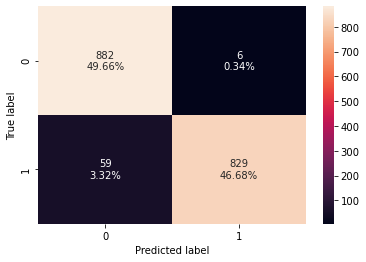

<IPython.core.display.Javascript object>

In [81]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_under, X_train_un, y_train_un)

In [82]:
# Calculating different metrics on validation set
tuned_rf_under_val = model_performance_classification_sklearn(
    tuned_rf_over, X_val, y_val
)
print("Validation performance:")
tuned_rf_under_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.988,0.860,0.918,0.888


<IPython.core.display.Javascript object>

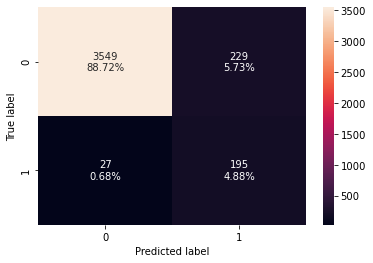

<IPython.core.display.Javascript object>

In [83]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_under, X_val, y_val)

* The model is slightly overfited.
* The prediction power of the model is 86% on recall score which is good.
* The run time for tuning the model hyperparameters are around 38s (by available resource).

## Tuning method for Xgboost with undersampled data

In [84]:
%%time

# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.924585793182251:
Wall time: 1min 52s


<IPython.core.display.Javascript object>

In [85]:
# Creating new pipeline with best parameters
tuned_xgb_under = XGBClassifier(
    n_estimators=250,
    scale_pos_weight=10,
    learning_rate=0.1,
    gamma=5,
    subsample=0.9,
    eval_metric="logloss",
)

# Fit the model on training data
tuned_xgb_under.fit(X_train_un, y_train_un)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [86]:
# Calculating different metrics on training set
tuned_xgb_under_train = model_performance_classification_sklearn(
    tuned_xgb_under, X_train_un, y_train_un
)
print("Training performance:")
tuned_xgb_under_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,1.000,0.990,0.995


<IPython.core.display.Javascript object>

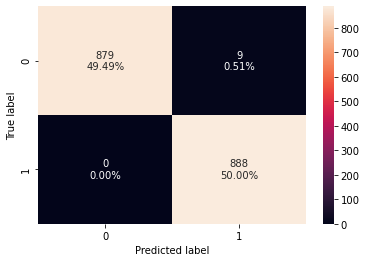

<IPython.core.display.Javascript object>

In [87]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_xgb_under, X_train_un, y_train_un)

In [88]:
# Calculating different metrics on validation set
tuned_xgb_under_val = model_performance_classification_sklearn(
    tuned_xgb_under, X_val, y_val
)
print("Validation performance:")
tuned_xgb_under_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.869,0.923,0.288,0.439


<IPython.core.display.Javascript object>

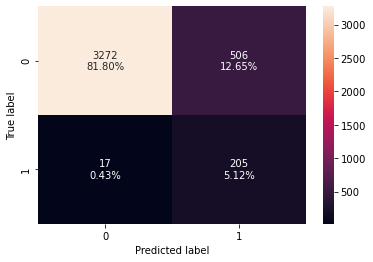

<IPython.core.display.Javascript object>

In [89]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_xgb_under, X_val, y_val)

* The model is slightly overfited.
* The prediction power of the model is 92% on recall score which is the best among all other methods.
* The run time for tuning the model hyperparameters are around 2min (by available resource).

## Model performance comparison and choosing the final model

In [90]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        tuned_Bagging_over_train.T,
        tuned_rf_over_train.T,
        tuned_xgb_over_train.T,
        tuned_gb_under_train.T,
        tuned_rf_under_train.T,
        tuned_xgb_under_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Bagging classifier tuned with oversampled data",
    "Random forest tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "Gradient Boosting tuned with undersampled data",
    "Random forest tuned with undersampled data",
    "XGBoost tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Bagging classifier tuned with oversampled data,Random forest tuned with oversampled data,XGBoost tuned with oversampled data,Gradient Boosting tuned with undersampled data,Random forest tuned with undersampled data,XGBoost tuned with undersampled data
Accuracy,1.000,1.000,0.998,0.993,0.963,0.995
Recall,1.000,0.999,1.000,0.988,0.934,1.000
Precision,1.000,1.000,0.996,0.999,0.993,0.990
F1,1.000,1.000,0.998,0.993,0.962,0.995


<IPython.core.display.Javascript object>

In [91]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        tuned_Bagging_over_val.T,
        tuned_rf_over_val.T,
        tuned_xgb_over_val.T,
        tuned_gb_under_val.T,
        tuned_rf_under_val.T,
        tuned_xgb_under_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Bagging classifier tuned with oversampled data",
    "Random forest tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "Gradient Boosting tuned with undersampled data",
    "Random forest tuned with undersampled data",
    "XGBoost tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Bagging classifier tuned with oversampled data,Random forest tuned with oversampled data,XGBoost tuned with oversampled data,Gradient Boosting tuned with undersampled data,Random forest tuned with undersampled data,XGBoost tuned with undersampled data
Accuracy,0.984,0.988,0.976,0.924,0.988,0.869
Recall,0.856,0.860,0.874,0.883,0.860,0.923
Precision,0.848,0.918,0.735,0.413,0.918,0.288
F1,0.852,0.888,0.798,0.562,0.888,0.439


<IPython.core.display.Javascript object>

* Comparing all the data shows that the oversampling in this datset make the data to be overfitted also after tuning.
* The unersampling is working much more better than oversamoling.
* Comparing the recall scores, XGBoost method has the highest score for undersampled data which is selected as the final model to proceed with that.

### Test set final performance

In [92]:
# Calculating different metrics on test set
tuned_xgb_under_test = model_performance_classification_sklearn(
    tuned_xgb_under, X_test, y_test
)
print("Test performance:")
tuned_xgb_under_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.868,0.887,0.285,0.432


<IPython.core.display.Javascript object>

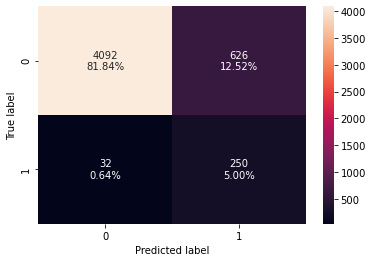

<IPython.core.display.Javascript object>

In [93]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_xgb_under, X_test, y_test)

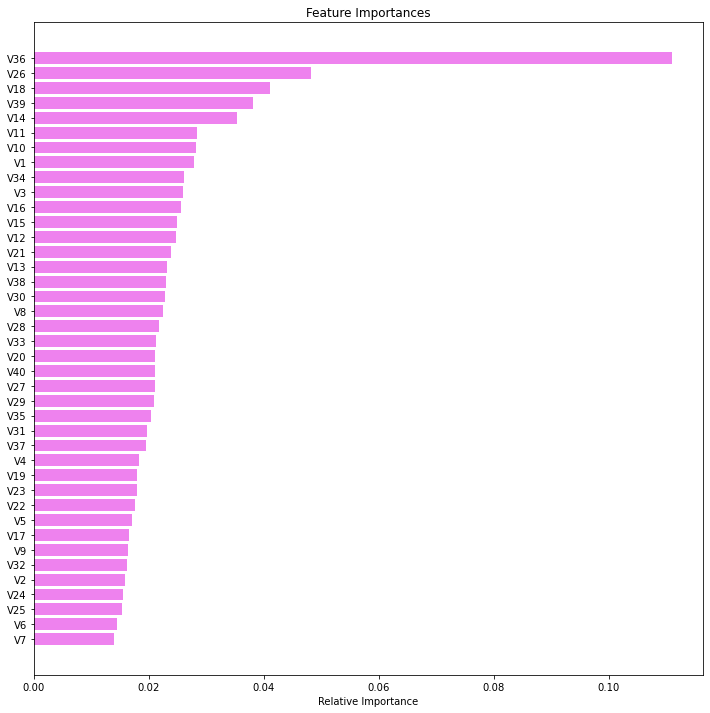

<IPython.core.display.Javascript object>

In [94]:
feature_names = X_train.columns
importances = tuned_xgb_under.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* Using the XGBoost on undersamoled data shows near 89% prediction power on test dataset which has been never seen.
* The most importamnt feature on prediction in feature V36 followed by V26, V18, V39, and V14.

## Pipelines to build the final model


 * Now, we have a final model. let's use pipelines to put the model into production.

In [95]:
# creating a list of numerical variables
numerical_features = ["V1", "V2"]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean"))])



preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features)],
    remainder="passthrough",
)


<IPython.core.display.Javascript object>

* Now we already know the best model we need to process with, so we don't need to divide data into 3 parts

In [96]:
# Random undersampler for under sampling the data
rus_p = RandomUnderSampler(random_state=1, sampling_strategy=1)

X_train_p = df_train.drop("Target", axis=1)
y_train_p = df_train["Target"]
X_test_p = df_test.drop("Target", axis=1)
y_test_p = df_test["Target"]


X_train_p_un, y_train_p_un = rus_p.fit_resample(X_train_p, y_train_p)

print(X_train_p_un.shape, X_test_p.shape)

(2220, 40) (5000, 40)


<IPython.core.display.Javascript object>

In [97]:
# Creating new pipeline with best parameters
model_pipe_under = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=250,
                scale_pos_weight=10,
                subsample=0.9,
                learning_rate=0.1,
                gamma=5,
                eval_metric="logloss",

            ),
        ),
    ]
)
# Fit the model on training data
model_pipe_under.fit(X_train_p_un, y_train_p_un)


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['V1', 'V2'])])),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=5, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=250,
            

<IPython.core.display.Javascript object>

In [98]:
# Let's check the performance on test set
Model_test = model_performance_classification_sklearn(
    model_pipe_under, X_test_p, y_test_p
)
Model_test

,Accuracy,Recall,Precision,F1
0,0.875,0.883,0.296,0.443


<IPython.core.display.Javascript object>

* As per previous investigation, the best model is chosen associated with its parameters.
* XGBoost model with undersampling technique is used in this pipeline for the final model.
* The performance on the test dataset is 88% for recall score.

# Business Insights and Conclusions

- The best score of recall is ~89% but the test precision is very low i.e ~30% at the same time. This means that the model is not good at identifying non-defaulter, which increase the inspection cost for the company.
- The model performance can be improved, especially in terms of precision and the company can use the model for new instalation once desired level of model performance is achieved.
- The most important features in final model were V36, followed by V26, V18, V39, and V14. The company can put more precise checklist for inspection of this variables.
- Undersampled moldes totally works better than the over sampled one because they did not overfitted the data as much as oversampling and the run time for undersampling data was too fast compare to the oversampled one. 
- The best model was XGBoost on undersampled data. But the models can be more investigated and playing with hyperparameters could help to improve the models performance.
- Working with ciphered data, make the problem more complicated. It is recommended using the unciphered data that might be easier to understand.
